In [1]:
scriptdirectory = r"C:/Users/User/Documents/JO/gitkraken/MEA_analysis/Tübingen_Branch"

input_directory = r"D:\Files_Reutlingen_Jenny\dataframes"
output_directory = r"D:\Files_Reutlingen_Jenny\dataframes"


In [2]:
import os
os.chdir(scriptdirectory)

import sys
import numpy as np
import pandas as pd
import importlib

import McsPy
import McsPy.McsData
import McsPy.McsCMOS
from McsPy import ureg, Q_

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from scipy.signal import butter, lfilter, freqz, find_peaks, correlate, gaussian, filtfilt
from scipy import stats
from scipy import signal

from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing

from Butterworth_Filter import butter_bandpass, butter_bandpass_filter

import glob
from plot_signal_and_spikes import plot_signal_and_spikes_from_bandpassfilteredsignal
import time

from neo.core import AnalogSignal
import quantities as pq

from elephant.spectral import welch_psd
from elephant.current_source_density import estimate_csd
import pickle
from pathlib import Path


import qgrid
import plotly.express as px
%matplotlib inline



### Load in all Dataframes from each recording

In [3]:
os.chdir(input_directory)
folderlist = glob.glob('*DATAFRAME*.pkl')

In [4]:
folderlist

['DATAFRAME_190415_01_Cortex-synChR2-A_aCSF_nodrug.pkl',
 'DATAFRAME_190415_02_Cortex-synChR2-A_hCSF_nodrug.pkl',
 'DATAFRAME_190416_01_cortex-GFP-B_aCSF_nodrug.pkl',
 'DATAFRAME_190416_02_cortex-GFP-B_hCSF_nodrug.pkl',
 'DATAFRAME_190416_03_cortex-GFP-B_aCSF_rewashafterhcsf.pkl',
 'DATAFRAME_190424_01_cortex-D_aCSF_nodrug.pkl',
 'DATAFRAME_190424_02_cortex-D_hCSF_nodrug.pkl',
 'DATAFRAME_190424_03_cortex-D_aCSF_rewashafterhCSF.pkl',
 'DATAFRAME_190425_01_cortex-E_aCSF_nodrug.pkl',
 'DATAFRAME_190425_02_cortex-E_hCSF_nodrug.pkl',
 'DATAFRAME_190425_03_cortex-E_aCSF_rewashafterhCSF.pkl',
 'DATAFRAME_191021_01_cortex_aCSF_nodrug.pkl',
 'DATAFRAME_191021_02_cortex_hCSF_nodrug.pkl']

In [5]:
# this concatenates all dataframes
df_from_each_file = (pickle.load(open(Path(input_directory, filename), "rb")) for filename in folderlist)
df   = pd.concat(df_from_each_file, ignore_index=True)

In [6]:
pd.options.display.max_columns = None

In [7]:
filenamelist = []

cut = lambda x: x.split('DATAFRAME_')[1].split('.pkl')[0]

In [8]:
filenamelist = [cut(i) for i in folderlist]

In [9]:
filenamelist

['190415_01_Cortex-synChR2-A_aCSF_nodrug',
 '190415_02_Cortex-synChR2-A_hCSF_nodrug',
 '190416_01_cortex-GFP-B_aCSF_nodrug',
 '190416_02_cortex-GFP-B_hCSF_nodrug',
 '190416_03_cortex-GFP-B_aCSF_rewashafterhcsf',
 '190424_01_cortex-D_aCSF_nodrug',
 '190424_02_cortex-D_hCSF_nodrug',
 '190424_03_cortex-D_aCSF_rewashafterhCSF',
 '190425_01_cortex-E_aCSF_nodrug',
 '190425_02_cortex-E_hCSF_nodrug',
 '190425_03_cortex-E_aCSF_rewashafterhCSF',
 '191021_01_cortex_aCSF_nodrug',
 '191021_02_cortex_hCSF_nodrug']

In [10]:
# if the index needs to be renumbered
#df = df.reset_index(drop=True)

In [11]:
df

filename recording_date  \
0     190415_01_Cortex-synChR2-A_aCSF_nodrug     2019-04-15   
1     190415_01_Cortex-synChR2-A_aCSF_nodrug     2019-04-15   
2     190415_01_Cortex-synChR2-A_aCSF_nodrug     2019-04-15   
3     190415_01_Cortex-synChR2-A_aCSF_nodrug     2019-04-15   
4     190415_01_Cortex-synChR2-A_aCSF_nodrug     2019-04-15   
...                                      ...            ...   
9636            191021_02_cortex_hCSF_nodrug     2019-10-21   
9637            191021_02_cortex_hCSF_nodrug     2019-10-21   
9638            191021_02_cortex_hCSF_nodrug     2019-10-21   
9639            191021_02_cortex_hCSF_nodrug     2019-10-21   
9640            191021_02_cortex_hCSF_nodrug     2019-10-21   

      timelength_recording_s  firingrate_whole_recording_Hz  \
0                     1800.0                        385.713   
1                     1800.0                        385.713   
2                     1800.0                        385.713   
3                     1800.0                        385.713   
4                     1800.0                        385.713   
...                      ...                            ...   
9636                   969.5                        347.728   
9637                   969.5                        347.728   
9638                   969.5                        347.728   
9639                   969.5                        347.728   
9640                   969.5                        347.728   

      active_channels_whole_recording  \
0                                 170   
1                                 170   
2                                 170   
3                                 170   
4                                 170   
...                               ...   
9636                              151   
9637                              151   
9638                              151   
9639                              151   
9640                              151   

                           network_burst_seconds  timelength_network_burst_s  \
0     (0.005639999999999999, 11.990568622864936)                   11.984929   
1        (12.725564245543762, 19.50052330121305)                    6.774959   
2        (19.60052330121305, 26.710480957330674)                    7.109958   
3        (27.22547789022808, 27.285476937341837)                    0.059999   
4        (27.38547693734184, 29.975461512495798)                    2.589985   
...                                          ...                         ...   
9636      (952.0994509864311, 953.2579695743703)                    1.158519   
9637       (953.6589952394262, 953.999628377574)                    0.340633   
9638       (954.099628377574, 954.3957031084933)                    0.296075   
9639      (954.4957031084933, 954.8610909173236)                    0.365388   
9640      (954.9610909173236, 955.6581913132989)                    0.697100   

                                      bursting_channels  \
0     [A11, A14, B11, B14, B5, C11, C12, C13, C15, C...   
1     [A14, B10, B11, C11, C12, C6, C7, D11, D12, D6...   
2     [A10, A11, B10, B11, B12, B5, C11, C6, C7, D15...   
3                                          [D7, H4, M2]   
4     [B11, C11, C13, C6, D11, D6, D7, D8, E10, E11,...   
...                                                 ...   
9636  [D3, E11, E2, F3, F5, F7, F8, G3, G7, H12, I10...   
9637            [E11, F2, F3, F5, F7, G7, K10, L10, L9]   
9638                 [D8, E3, F3, F7, G7, K10, K8, L10]   
9639  [E11, F3, F7, G7, I10, K10, K11, K6, K8, L10, ...   
9640  [E2, F3, F5, F7, G3, G7, G9, I10, K10, K11, K6...   

      number_of_bursting_channels  number_burst_starts  number_burst_ends  \
0                              90                  286                286   
1                              67                  159                159   
2                              73                  154                154   
3                               3                  

### Preparation of the dataframe: Cleaning and further variables

In [12]:
# dichotomizing column is added whether at least one deviation 

df.loc[df['number_channels_with_lfp_down'] == 0, 'any_lfp_deviation'] = 0
df.loc[df['number_channels_with_lfp_up'] == 0, 'any_lfp_deviation'] = 0
df.loc[df['number_channels_with_lfp_down'] > 0, 'any_lfp_deviation'] = 1
df.loc[df['number_channels_with_lfp_down'] > 0, 'any_lfp_deviation'] = 1


In [13]:
df

filename recording_date  \
0     190415_01_Cortex-synChR2-A_aCSF_nodrug     2019-04-15   
1     190415_01_Cortex-synChR2-A_aCSF_nodrug     2019-04-15   
2     190415_01_Cortex-synChR2-A_aCSF_nodrug     2019-04-15   
3     190415_01_Cortex-synChR2-A_aCSF_nodrug     2019-04-15   
4     190415_01_Cortex-synChR2-A_aCSF_nodrug     2019-04-15   
...                                      ...            ...   
9636            191021_02_cortex_hCSF_nodrug     2019-10-21   
9637            191021_02_cortex_hCSF_nodrug     2019-10-21   
9638            191021_02_cortex_hCSF_nodrug     2019-10-21   
9639            191021_02_cortex_hCSF_nodrug     2019-10-21   
9640            191021_02_cortex_hCSF_nodrug     2019-10-21   

      timelength_recording_s  firingrate_whole_recording_Hz  \
0                     1800.0                        385.713   
1                     1800.0                        385.713   
2                     1800.0                        385.713   
3                     1800.0                        385.713   
4                     1800.0                        385.713   
...                      ...                            ...   
9636                   969.5                        347.728   
9637                   969.5                        347.728   
9638                   969.5                        347.728   
9639                   969.5                        347.728   
9640                   969.5                        347.728   

      active_channels_whole_recording  \
0                                 170   
1                                 170   
2                                 170   
3                                 170   
4                                 170   
...                               ...   
9636                              151   
9637                              151   
9638                              151   
9639                              151   
9640                              151   

                           network_burst_seconds  timelength_network_burst_s  \
0     (0.005639999999999999, 11.990568622864936)                   11.984929   
1        (12.725564245543762, 19.50052330121305)                    6.774959   
2        (19.60052330121305, 26.710480957330674)                    7.109958   
3        (27.22547789022808, 27.285476937341837)                    0.059999   
4        (27.38547693734184, 29.975461512495798)                    2.589985   
...                                          ...                         ...   
9636      (952.0994509864311, 953.2579695743703)                    1.158519   
9637       (953.6589952394262, 953.999628377574)                    0.340633   
9638       (954.099628377574, 954.3957031084933)                    0.296075   
9639      (954.4957031084933, 954.8610909173236)                    0.365388   
9640      (954.9610909173236, 955.6581913132989)                    0.697100   

                                      bursting_channels  \
0     [A11, A14, B11, B14, B5, C11, C12, C13, C15, C...   
1     [A14, B10, B11, C11, C12, C6, C7, D11, D12, D6...   
2     [A10, A11, B10, B11, B12, B5, C11, C6, C7, D15...   
3                                          [D7, H4, M2]   
4     [B11, C11, C13, C6, D11, D6, D7, D8, E10, E11,...   
...                                                 ...   
9636  [D3, E11, E2, F3, F5, F7, F8, G3, G7, H12, I10...   
9637            [E11, F2, F3, F5, F7, G7, K10, L10, L9]   
9638                 [D8, E3, F3, F7, G7, K10, K8, L10]   
9639  [E11, F3, F7, G7, I10, K10, K11, K6, K8, L10, ...   
9640  [E2, F3, F5, F7, G3, G7, G9, I10, K10, K11, K6...   

      number_of_bursting_channels  number_burst_starts  number_burst_ends  \
0                              90                  286                286   
1                              67                  159                159   
2                              73                  154                154   
3                               3                  

In [14]:
# filter out artefacts by number of ative channels > 250

df = df.loc[(df['number_of_active_channels'] <= 250)]

In [15]:
len(df)

9631

In [18]:
# filter out channels with low active channels, i.e., < 10 % of totally active channels

df = df.loc[(df['number_of_active_channels'] > 0.1*df['active_channels_whole_recording'])]
df = df.loc[(df['number_of_active_channels'] > 5)]




In [19]:
len(df)

6043

In [20]:
# get a clean meadium from the filename
df['medium'] = df['filename'].str.split('_').str[3]
df['drug'] = df['filename'].str.split('_').str[4]
df.loc[(df['medium'] == 'aCSF'), 'num_medium'] = 1
df.loc[(df['medium'] == 'hCSF'), 'num_medium'] = 2

In [21]:
df

filename recording_date  \
0     190415_01_Cortex-synChR2-A_aCSF_nodrug     2019-04-15   
1     190415_01_Cortex-synChR2-A_aCSF_nodrug     2019-04-15   
2     190415_01_Cortex-synChR2-A_aCSF_nodrug     2019-04-15   
3     190415_01_Cortex-synChR2-A_aCSF_nodrug     2019-04-15   
4     190415_01_Cortex-synChR2-A_aCSF_nodrug     2019-04-15   
...                                      ...            ...   
9636            191021_02_cortex_hCSF_nodrug     2019-10-21   
9637            191021_02_cortex_hCSF_nodrug     2019-10-21   
9638            191021_02_cortex_hCSF_nodrug     2019-10-21   
9639            191021_02_cortex_hCSF_nodrug     2019-10-21   
9640            191021_02_cortex_hCSF_nodrug     2019-10-21   

      timelength_recording_s  firingrate_whole_recording_Hz  \
0                     1800.0                        385.713   
1                     1800.0                        385.713   
2                     1800.0                        385.713   
3                     1800.0                        385.713   
4                     1800.0                        385.713   
...                      ...                            ...   
9636                   969.5                        347.728   
9637                   969.5                        347.728   
9638                   969.5                        347.728   
9639                   969.5                        347.728   
9640                   969.5                        347.728   

      active_channels_whole_recording  \
0                                 170   
1                                 170   
2                                 170   
3                                 170   
4                                 170   
...                               ...   
9636                              151   
9637                              151   
9638                              151   
9639                              151   
9640                              151   

                           network_burst_seconds  timelength_network_burst_s  \
0     (0.005639999999999999, 11.990568622864936)                   11.984929   
1        (12.725564245543762, 19.50052330121305)                    6.774959   
2        (19.60052330121305, 26.710480957330674)                    7.109958   
3        (27.22547789022808, 27.285476937341837)                    0.059999   
4        (27.38547693734184, 29.975461512495798)                    2.589985   
...                                          ...                         ...   
9636      (952.0994509864311, 953.2579695743703)                    1.158519   
9637       (953.6589952394262, 953.999628377574)                    0.340633   
9638       (954.099628377574, 954.3957031084933)                    0.296075   
9639      (954.4957031084933, 954.8610909173236)                    0.365388   
9640      (954.9610909173236, 955.6581913132989)                    0.697100   

                                      bursting_channels  \
0     [A11, A14, B11, B14, B5, C11, C12, C13, C15, C...   
1     [A14, B10, B11, C11, C12, C6, C7, D11, D12, D6...   
2     [A10, A11, B10, B11, B12, B5, C11, C6, C7, D15...   
3                                          [D7, H4, M2]   
4     [B11, C11, C13, C6, D11, D6, D7, D8, E10, E11,...   
...                                                 ...   
9636  [D3, E11, E2, F3, F5, F7, F8, G3, G7, H12, I10...   
9637            [E11, F2, F3, F5, F7, G7, K10, L10, L9]   
9638                 [D8, E3, F3, F7, G7, K10, K8, L10]   
9639  [E11, F3, F7, G7, I10, K10, K11, K6, K8, L10, ...   
9640  [E2, F3, F5, F7, G3, G7, G9, I10, K10, K11, K6...   

      number_of_bursting_channels  number_burst_starts  number_burst_ends  \
0                              90                  286                286   
1                              67                  159                159   
2                              73                  154                154   
3                               3                  

In [22]:
# additional feature: ratio of bursting channels to active channels

df = df.assign(bursting_to_active_channels_ratio=lambda df: df.number_of_bursting_channels / df.number_of_active_channels)

In [23]:
# intra networkburst firing rate

df = df.assign(networkburst_firing_rate=lambda df: df.number_of_spikes/df.timelength_network_burst_s)

In [24]:
# getting the anatomy in percent
df = df.assign(layer1_percent_of_active_channels=lambda df: df.n_layer1_active_channels/df.number_of_active_channels)
df = df.assign(layer23_percent_of_active_channels=lambda df: df.n_layer23_active_channels/df.number_of_active_channels)
df = df.assign(layer4_percent_of_active_channels=lambda df: df.n_layer4_active_channels/df.number_of_active_channels)
df = df.assign(layer56_percent_of_active_channels=lambda df: df.n_layer56_active_channels/df.number_of_active_channels)
df = df.assign(whitematter_percent_of_active_channels=lambda df: df.n_whitematter_active_channels/df.number_of_active_channels)

In [25]:
# getting the anatomy in percent of all channels covered by the respective layer
df = df.assign(layer1_percent_of_covered_channels=lambda df: df.n_layer1_active_channels/df.channels_covered_layer1)
df = df.assign(layer23_percent_of_covered_channels=lambda df: df.n_layer23_active_channels/df.channels_covered_layer23)
df = df.assign(layer4_percent_of_covered_channels=lambda df: df.n_layer4_active_channels/df.channels_covered_layer4)
df = df.assign(layer56_percent_of_covered_channels=lambda df: df.n_layer56_active_channels/df.channels_covered_layer56)
df = df.assign(whitematter_percent_of_covered_channels=lambda df: df.n_whitematter_active_channels/df.channels_covered_whitematter)

In [26]:
# firing rate per layer for each networkburst
df = df.assign(layer1_firing_rate=lambda df: df.n_spikes_layer1/df.timelength_network_burst_s)
df = df.assign(layer23_firing_rate=lambda df: df.n_spikes_layer23/df.timelength_network_burst_s)
df = df.assign(layer4_firing_rate=lambda df: df.n_spikes_layer4/df.timelength_network_burst_s)
df = df.assign(layer56_firing_rate=lambda df: df.n_spikes_layer56/df.timelength_network_burst_s)
df = df.assign(whitematter_firing_rate=lambda df: df.n_spikes_whitematter/df.timelength_network_burst_s)

In [27]:
# number of channels with any lfp

df = df.assign(number_channels_with_any_lfp = lambda df: df.number_channels_with_lfp_up + df.number_channels_with_lfp_down)

In [28]:
df

filename recording_date  \
0     190415_01_Cortex-synChR2-A_aCSF_nodrug     2019-04-15   
1     190415_01_Cortex-synChR2-A_aCSF_nodrug     2019-04-15   
2     190415_01_Cortex-synChR2-A_aCSF_nodrug     2019-04-15   
3     190415_01_Cortex-synChR2-A_aCSF_nodrug     2019-04-15   
4     190415_01_Cortex-synChR2-A_aCSF_nodrug     2019-04-15   
...                                      ...            ...   
9636            191021_02_cortex_hCSF_nodrug     2019-10-21   
9637            191021_02_cortex_hCSF_nodrug     2019-10-21   
9638            191021_02_cortex_hCSF_nodrug     2019-10-21   
9639            191021_02_cortex_hCSF_nodrug     2019-10-21   
9640            191021_02_cortex_hCSF_nodrug     2019-10-21   

      timelength_recording_s  firingrate_whole_recording_Hz  \
0                     1800.0                        385.713   
1                     1800.0                        385.713   
2                     1800.0                        385.713   
3                     1800.0                        385.713   
4                     1800.0                        385.713   
...                      ...                            ...   
9636                   969.5                        347.728   
9637                   969.5                        347.728   
9638                   969.5                        347.728   
9639                   969.5                        347.728   
9640                   969.5                        347.728   

      active_channels_whole_recording  \
0                                 170   
1                                 170   
2                                 170   
3                                 170   
4                                 170   
...                               ...   
9636                              151   
9637                              151   
9638                              151   
9639                              151   
9640                              151   

                           network_burst_seconds  timelength_network_burst_s  \
0     (0.005639999999999999, 11.990568622864936)                   11.984929   
1        (12.725564245543762, 19.50052330121305)                    6.774959   
2        (19.60052330121305, 26.710480957330674)                    7.109958   
3        (27.22547789022808, 27.285476937341837)                    0.059999   
4        (27.38547693734184, 29.975461512495798)                    2.589985   
...                                          ...                         ...   
9636      (952.0994509864311, 953.2579695743703)                    1.158519   
9637       (953.6589952394262, 953.999628377574)                    0.340633   
9638       (954.099628377574, 954.3957031084933)                    0.296075   
9639      (954.4957031084933, 954.8610909173236)                    0.365388   
9640      (954.9610909173236, 955.6581913132989)                    0.697100   

                                      bursting_channels  \
0     [A11, A14, B11, B14, B5, C11, C12, C13, C15, C...   
1     [A14, B10, B11, C11, C12, C6, C7, D11, D12, D6...   
2     [A10, A11, B10, B11, B12, B5, C11, C6, C7, D15...   
3                                          [D7, H4, M2]   
4     [B11, C11, C13, C6, D11, D6, D7, D8, E10, E11,...   
...                                                 ...   
9636  [D3, E11, E2, F3, F5, F7, F8, G3, G7, H12, I10...   
9637            [E11, F2, F3, F5, F7, G7, K10, L10, L9]   
9638                 [D8, E3, F3, F7, G7, K10, K8, L10]   
9639  [E11, F3, F7, G7, I10, K10, K11, K6, K8, L10, ...   
9640  [E2, F3, F5, F7, G3, G7, G9, I10, K10, K11, K6...   

      number_of_bursting_channels  number_burst_starts  number_burst_ends  \
0                              90                  286                286   
1                              67                  159                159   
2                              73                  154                154   
3                               3                  

In [29]:
filename = df['filename'][0]

In [30]:
for i in filenamelist:
    saveframe = df.loc[(df['filename'] == i)]
    saveframe = saveframe.reset_index()
    saveframe.to_excel('overview_features_networkbursts_' + i + '.xlsx')

In [31]:
#df.to_excel('overview_features_networkbursts_' + filename + '_jo.xlsx')

In [32]:
df[(df['number_channels_with_any_lfp'] > 125)]

filename recording_date  \
114        190415_01_Cortex-synChR2-A_aCSF_nodrug     2019-04-15   
134        190415_01_Cortex-synChR2-A_aCSF_nodrug     2019-04-15   
137        190415_01_Cortex-synChR2-A_aCSF_nodrug     2019-04-15   
147        190415_01_Cortex-synChR2-A_aCSF_nodrug     2019-04-15   
308        190415_01_Cortex-synChR2-A_aCSF_nodrug     2019-04-15   
407        190415_01_Cortex-synChR2-A_aCSF_nodrug     2019-04-15   
408        190415_01_Cortex-synChR2-A_aCSF_nodrug     2019-04-15   
550        190415_01_Cortex-synChR2-A_aCSF_nodrug     2019-04-15   
620        190415_01_Cortex-synChR2-A_aCSF_nodrug     2019-04-15   
621        190415_01_Cortex-synChR2-A_aCSF_nodrug     2019-04-15   
783        190415_02_Cortex-synChR2-A_hCSF_nodrug     2019-04-15   
2038           190416_01_cortex-GFP-B_aCSF_nodrug     2019-04-16   
2268           190416_01_cortex-GFP-B_aCSF_nodrug     2019-04-16   
2269           190416_01_cortex-GFP-B_aCSF_nodrug     2019-04-16   
2313           190416_01_cortex-GFP-B_aCSF_nodrug     2019-04-16   
2859           190416_02_cortex-GFP-B_hCSF_nodrug     2019-04-16   
3159           190416_02_cortex-GFP-B_hCSF_nodrug     2019-04-16   
4076  190416_03_cortex-GFP-B_aCSF_rewashafterhcsf     2019-04-16   
4119  190416_03_cortex-GFP-B_aCSF_rewashafterhcsf     2019-04-16   
4512               190424_01_cortex-D_aCSF_nodrug     2019-04-24   
4519               190424_01_cortex-D_aCSF_nodrug     2019-04-24   
6272      190424_03_cortex-D_aCSF_rewashafterhCSF     2019-04-24   
6320               190425_01_cortex-E_aCSF_nodrug     2019-04-25   
6373               190425_01_cortex-E_aCSF_nodrug     2019-04-25   
6417               190425_01_cortex-E_aCSF_nodrug     2019-04-25   
6480               190425_01_cortex-E_aCSF_nodrug     2019-04-25   
6523               190425_01_cortex-E_aCSF_nodrug     2019-04-25   
6567               190425_01_cortex-E_aCSF_nodrug     2019-04-25   
6579               190425_01_cortex-E_aCSF_nodrug     2019-04-25   
6602               190425_01_cortex-E_aCSF_nodrug     2019-04-25   
6629               190425_01_cortex-E_aCSF_nodrug     2019-04-25   
6661               190425_01_cortex-E_aCSF_nodrug     2019-04-25   
6712               190425_01_cortex-E_aCSF_nodrug     2019-04-25   
6756               190425_01_cortex-E_aCSF_nodrug     2019-04-25   
6809               190425_01_cortex-E_aCSF_nodrug     2019-04-25   
6843               190425_01_cortex-E_aCSF_nodrug     2019-04-25   
6873               190425_01_cortex-E_aCSF_nodrug     2019-04-25   
6899               190425_01_cortex-E_aCSF_nodrug     2019-04-25   
6922               190425_01_cortex-E_aCSF_nodrug     2019-04-25   
7030               190425_01_cortex-E_aCSF_nodrug     2019-04-25   
7038               190425_01_cortex-E_aCSF_nodrug     2019-04-25   
7095               190425_01_cortex-E_aCSF_nodrug     2019-04-25   
7134               190425_01_cortex-E_aCSF_nodrug     2019-04-25   

      timelength_recording_s  firingrate_whole_recording_Hz  \
114                   1800.0                        385.713   
134                   1800.0                        385.713   
137                   1800.0                        385.713   
147                   1800.0                        385.713   
308                   1800.0                        385.713   
407                   1800.0                        385.713   
408                   1800.0                        385.713   
550                   1800.0                        385.713   
620                   1800.0                        385.713   
621                   1800.0                        385.713   
783                   1800.0                         46.096   
2038                  1800.0                       1262.617   
2268                  1800.0                       1262.617   
2269                  1800.0                       1262.617   
2313                  1800.0                       1262.617   
2859                  1800.0            

In [422]:
#df.loc[(df['recording_date'] == '2019-04-16') & (df['number_channels_with_any_lfp']>0)]

In [423]:
df1604 = df.loc[(df['recording_date'] == '2019-04-16')]

In [424]:
df1604.groupby('medium')['number_channels_with_any_lfp'].describe()

count      mean        std  min  25%  50%  75%    max
medium                                                        
aCSF    1111.0  2.432043  21.673013  0.0  0.0  0.0  0.0  490.0
hCSF    1066.0  0.951220  11.765449  0.0  0.0  0.0  0.0  328.0

<AxesSubplot:title={'center':'number_channels_with_any_lfp'}, xlabel='medium'>

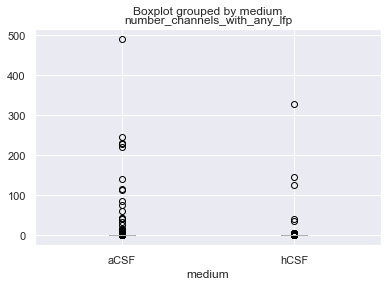

In [425]:
df1604.boxplot(column=['number_channels_with_any_lfp'], by='medium')

In [426]:
df1604.loc[(df1604['number_channels_with_any_lfp'] < 30)].groupby('medium')['number_channels_with_any_lfp'].describe()

count      mean       std  min  25%  50%  75%   max
medium                                                      
aCSF    1096.0  0.484489  1.597297  0.0  0.0  0.0  0.0  27.0
hCSF    1061.0  0.318567  0.724454  0.0  0.0  0.0  0.0   6.0

In [33]:
df.columns

Index(['filename', 'recording_date', 'timelength_recording_s',
       'firingrate_whole_recording_Hz', 'active_channels_whole_recording',
       'network_burst_seconds', 'timelength_network_burst_s',
       'bursting_channels', 'number_of_bursting_channels',
       'number_burst_starts', 'number_burst_ends', 'active_channels_total',
       'number_of_active_channels', 'number_of_spikes', 'channels_lfp_up',
       'number_channels_with_lfp_up', 'mean_up_lfp_amplitude',
       'channels_lfp_down', 'number_channels_with_lfp_down',
       'mean_down_lfp_amplitude', 'n_layer1_active_channels',
       'n_layer23_active_channels', 'n_layer4_active_channels',
       'n_layer56_active_channels', 'n_whitematter_active_channels',
       'n_spikes_layer1', 'n_spikes_layer23', 'n_spikes_layer4',
       'n_spikes_layer56', 'n_spikes_whitematter', 'isi_mean_layer1_microsec',
       'isi_mean_layer23_microsec', 'isi_mean_layer4_microsec',
       'isi_mean_layer56_microsec', 'isi_mean_whitematter_micro

In [34]:
groups = df.groupby('filename')

In [42]:
df.corr(method='pearson')

timelength_recording_s  \
timelength_recording_s                                 1.000000   
firingrate_whole_recording_Hz                          0.237160   
active_channels_whole_recording                       -0.040092   
timelength_network_burst_s                             0.100328   
number_of_bursting_channels                            0.185745   
number_burst_starts                                    0.122957   
number_burst_ends                                      0.122957   
number_of_active_channels                              0.087290   
number_of_spikes                                       0.156788   
number_channels_with_lfp_up                            0.027874   
mean_up_lfp_amplitude                                  0.095998   
number_channels_with_lfp_down                          0.038000   
mean_down_lfp_amplitude                                0.082721   
n_layer1_active_channels                               0.207873   
n_layer23_active_channels                              0.181871   
n_layer4_active_channels                              -0.419404   
n_layer56_active_channels                              0.115875   
n_whitematter_active_channels                         -0.109701   
n_spikes_layer1                                        0.101253   
n_spikes_layer23                                       0.115114   
n_spikes_layer4                                       -0.071741   
n_spikes_layer56                                       0.163761   
n_spikes_whitematter                                   0.048538   
isi_mean_layer1_microsec                                    NaN   
isi_mean_layer23_microsec                              0.013052   
isi_mean_layer4_microsec                               0.083891   
isi_mean_layer56_microsec                              0.132793   
isi_mean_whitematter_microsec                          0.145323   
isi_std_layer1                                              NaN   
isi_std_layer23                                        0.062923   
isi_std_layer4                                         0.127887   
isi_std_layer56                                        0.014006   
isi_std_whitematter'                                   0.071136   
channels_covered_layer1                                0.236327   
channels_covered_layer23                              -0.346436   
channels_covered_layer4                               -0.452460   
channels_covered_layer56                               0.659019   
channels_covered_whitematter                          -0.349517   
any_lfp_deviation                                      0.000088   
num_medium                                             0.058681   
bursting_to_active_channels_ratio                      0.018289   
networkburst_firing_rate                               0.235760   
layer1_percent_of_active_channels                      0.178665   
layer23_percent_of_active_channels                     0.182379   
layer4_percent_of_active_channels                     -0.657075   
layer56_percent_of_active_channels                     0.006373   
whitematter_percent_of_active_channels                 0.055137   
layer1_percent_of_covered_channels                          NaN   
layer23_percent_of_covered_channels                    0.333546   
layer4_percent_of_covered_channels                    -0.080219   
layer56_percent_of_covered_channels                   -0.059183   
whitematter_percent_of_covered_channels                0.075496   
layer1_firing_rate                                     0.143071   
layer23_firing_rate                                    0.159321   
layer4_firing_rate                                    -0.368345   
layer56_firing_rate                                    0.247481   
whitematter_firing_rate                                0.031157   
number_channels_with_any_lfp                           0.037510   

                                         firingrate_whole_recording_Hz  \
timelength_re

In [332]:
dfoi = df[df.columns & interesting_features]

C:\Users\User\AppData\Local\Temp/ipykernel_16528/2048167548.py:1: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  dfoi = df[df.columns & interesting_features]


In [333]:
dfoi

number_of_bursting_channels  isi_mean_layer23_microsec  \
0                              90                   7.344358   
1                              67                   6.303568   
2                              73                   5.988145   
3                               3                   0.358933   
4                              44                   5.382082   
...                           ...                        ...   
5260                           21                  30.715200   
5261                            9                        NaN   
5262                            8                   6.307200   
5263                           12                        NaN   
5264                           13                        NaN   

      isi_mean_layer56_microsec medium  layer23_percent_of_active_channels  \
0                     11.334750   aCSF                            0.367470   
1                     10.118867   aCSF                            0.384106   
2                      9.473602   aCSF                            0.351724   
3                      0.987600   aCSF                            0.476190   
4                      6.849259   aCSF                            0.383333   
...                         ...    ...                                 ...   
5260                   4.652431   hCSF                            0.076923   
5261                   2.490439   hCSF                            0.062500   
5262                   1.256889   hCSF                            0.021277   
5263                   1.816747   hCSF                            0.058824   
5264                   3.720049   hCSF                            0.026316   

      layer56_percent_of_active_channels  
0                               0.421687  
1                               0.403974  
2                               0.420690  
3                               0.333333  
4                               0.425000  
...                                  ...  
5260                            0.692308  
5261                            0.796875  
5262                            0.829787  
5263                            0.725490  
5264                            0.750000  

[4507 rows x 6 columns]

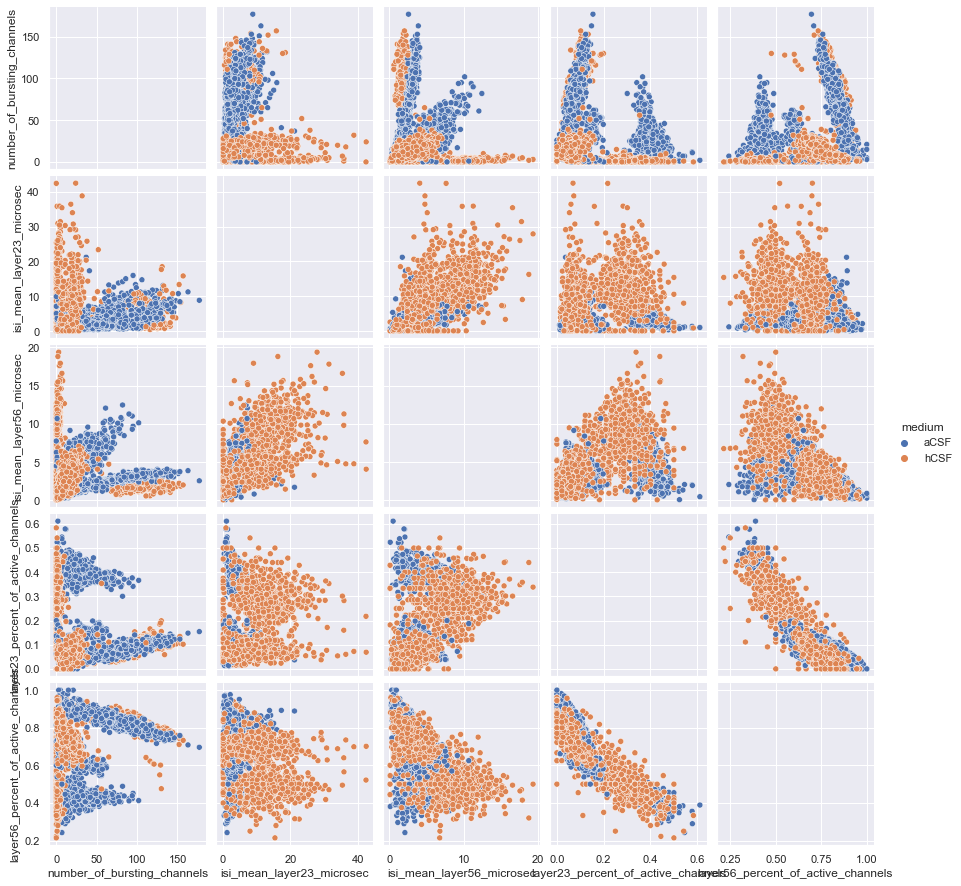

In [334]:
g = sns.pairplot(data=dfoi, hue="medium", diag_kind="reg", height=2.5)

### Data Exploration using Seaborn, Holoview, Plotly

In [38]:
import seaborn as sns

In [39]:
grouper = 'recording_date'
grouped = df[grouper].unique()


C:\Users\User\AppData\Local\Temp/ipykernel_11276/2267091698.py:6: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  dfoi = df_of_interest[df_of_interest.columns & interesting_features]
C:\Users\User\AppData\Local\Temp/ipykernel_11276/2267091698.py:6: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  dfoi = df_of_interest[df_of_interest.columns & interesting_features]
C:\Users\User\AppData\Local\Temp/ipykernel_11276/2267091698.py:6: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  dfoi = df_of_interest[df_of_interest.columns & interesting_features]


ZeroDivisionError: division by zero

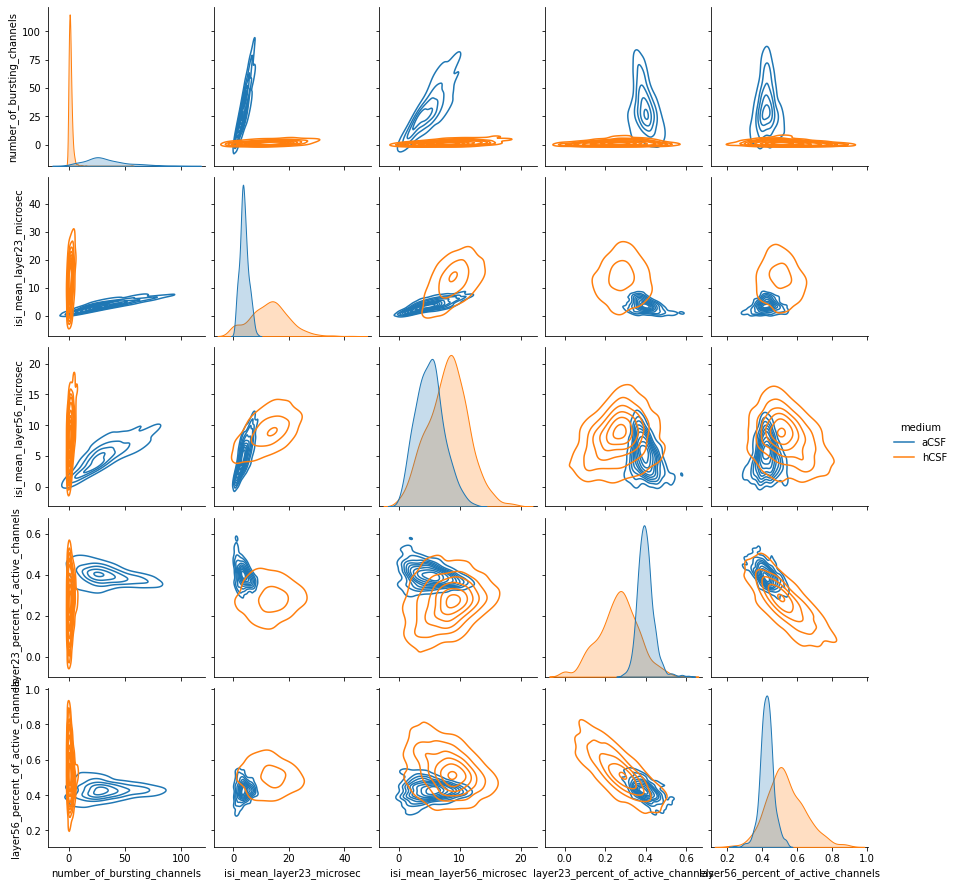

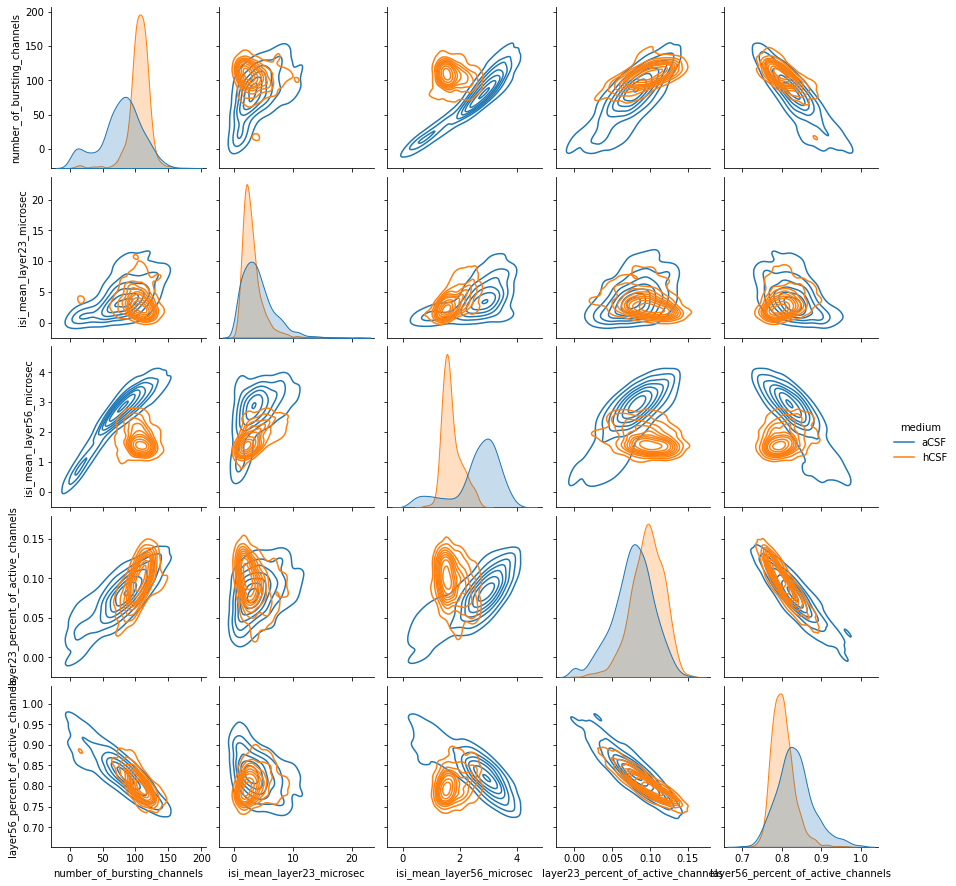

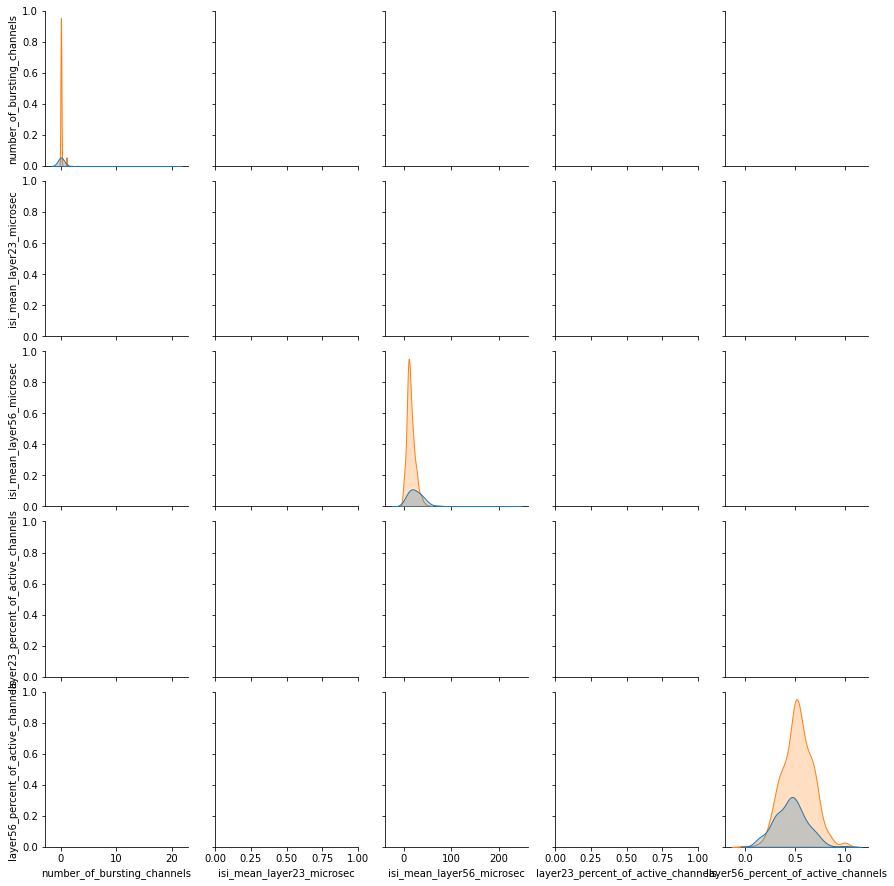

In [40]:
interesting_features = ['number_of_bursting_channels', 'isi_mean_layer23_microsec', 
                        'isi_mean_layer56_microsec', 'layer23_percent_of_active_channels',
                        'layer56_percent_of_active_channels', 'medium']
for i in grouped:
    df_of_interest = df.loc[(df[grouper] == i)]
    dfoi = df_of_interest[df_of_interest.columns & interesting_features]

    g = sns.pairplot(data=dfoi, hue="medium", diag_kind="kde", height=2.5, kind='kde')
    g.figure.savefig('trial_'+i+'.png')

C:\Users\User\AppData\Local\Temp/ipykernel_16528/1591369441.py:9: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  dfoi = df_of_interest[df_of_interest.columns & interesting_features]
C:\Users\User\AppData\Local\Temp/ipykernel_16528/1591369441.py:9: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  dfoi = df_of_interest[df_of_interest.columns & interesting_features]
C:\Users\User\AppData\Local\Temp/ipykernel_16528/1591369441.py:9: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  dfoi = df_of_interest[df_of_interest.columns & interesting_features]


ZeroDivisionError: division by zero

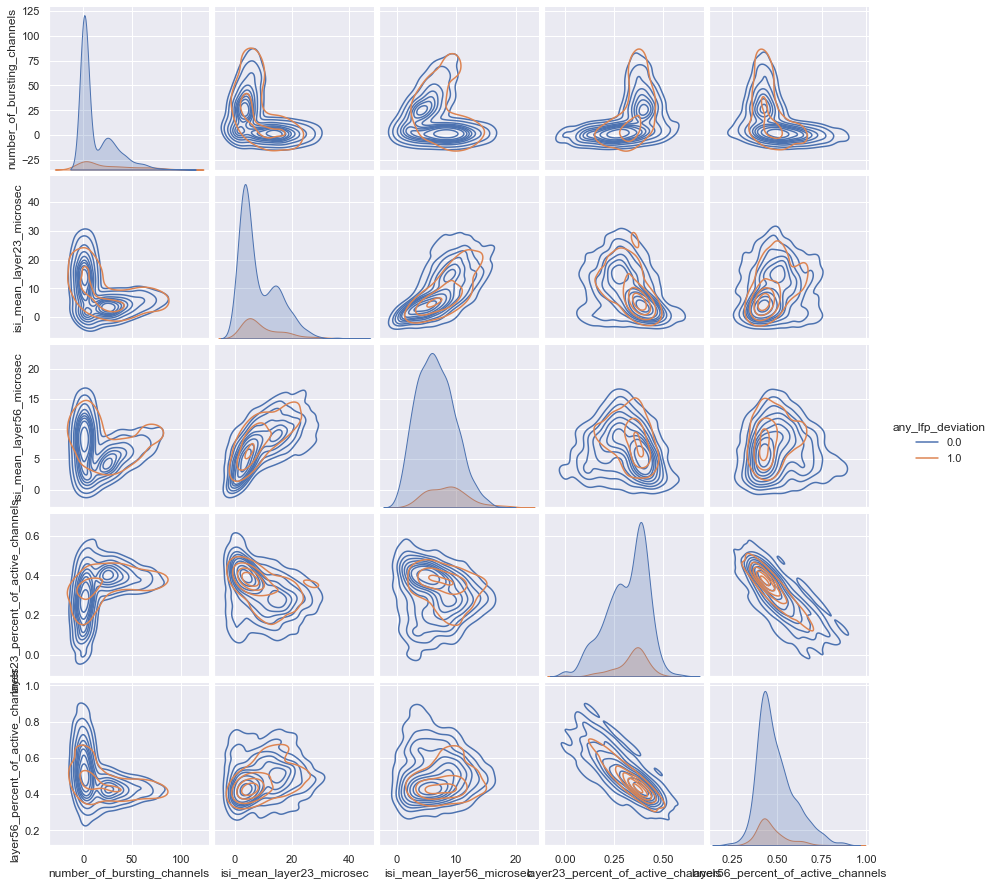

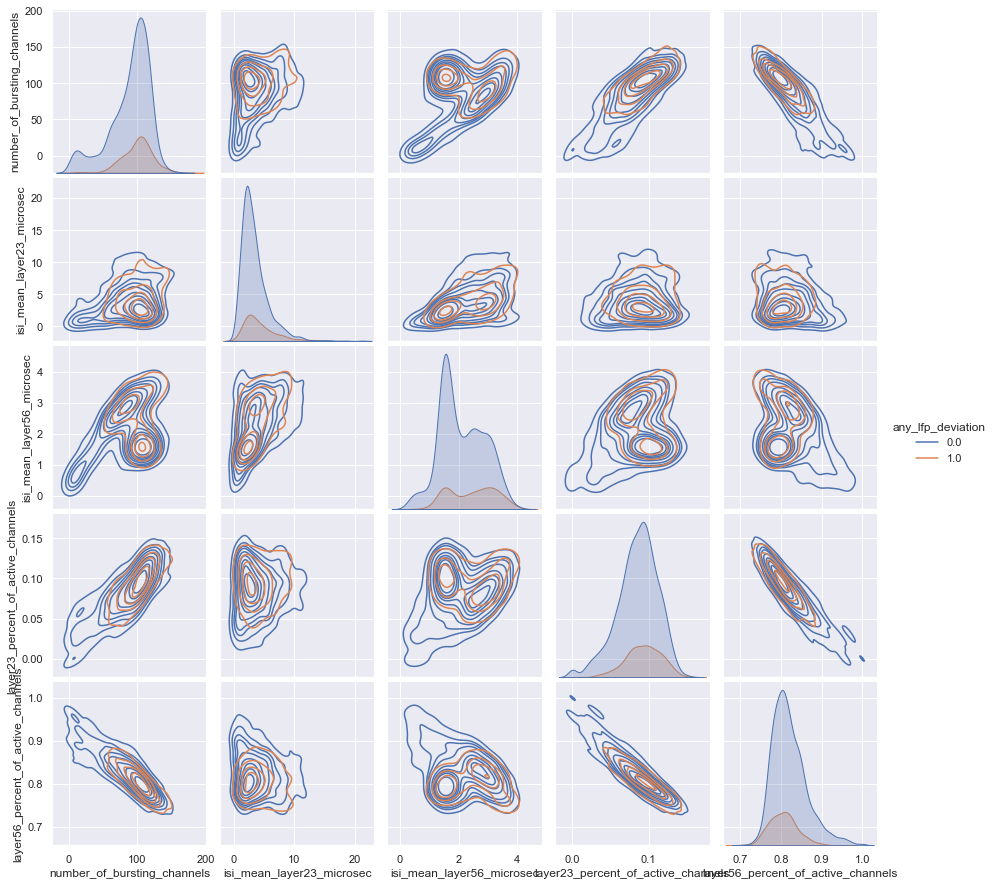

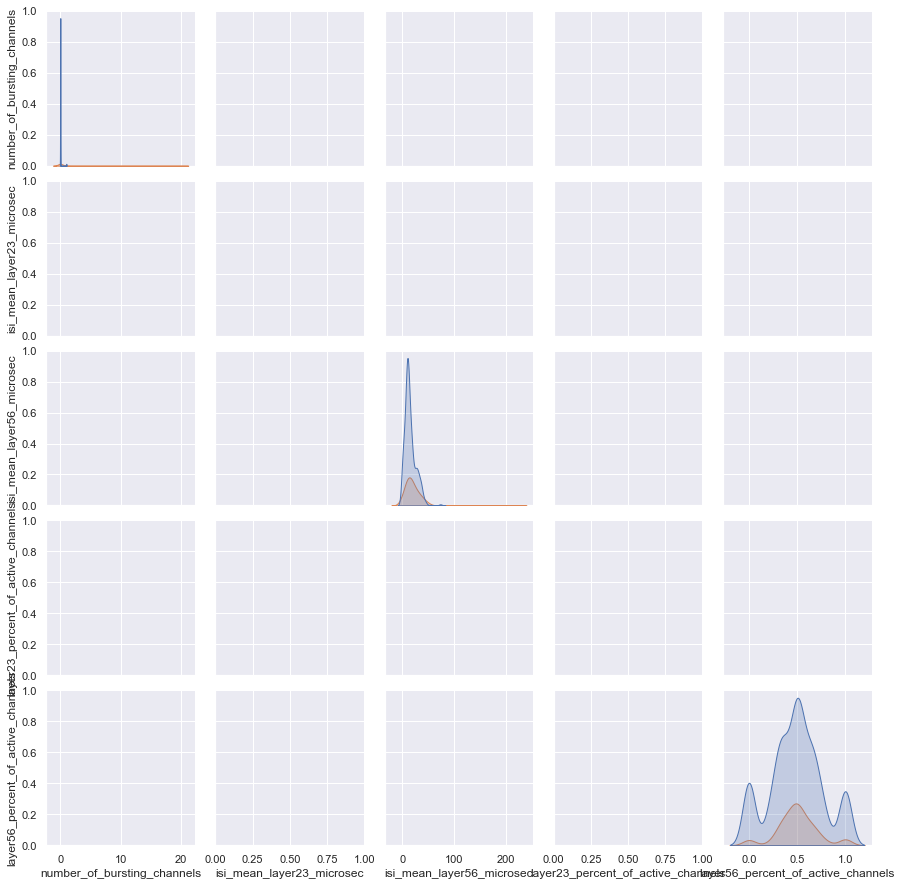

In [432]:
interesting_features = ['number_of_bursting_channels', 'isi_mean_layer23_microsec', 
                        'isi_mean_layer56_microsec', 'layer23_percent_of_active_channels',
                        'layer56_percent_of_active_channels', 'any_lfp_deviation']



for i in grouped:
    df_of_interest = df.loc[(df[grouper] == i)]
    dfoi = df_of_interest[df_of_interest.columns & interesting_features]
    
    #fig, ax = plt.subplots(1,1, figsize=(12,12))
    
    g = sns.pairplot(data=dfoi, hue="any_lfp_deviation", diag_kind="kde", height=2.5, kind='kde')
    g.figure.savefig('trial_'+i+'.png')

In [433]:
grouped

array(['2019-04-15', '2019-04-16', '2019-04-24', '2019-10-21'],
      dtype=object)

In [434]:
df.columns

Index(['filename', 'recording_date', 'timelength_recording_s',
       'firingrate_whole_recording_Hz', 'active_channels_whole_recording',
       'network_burst_seconds', 'timelength_network_burst_s',
       'bursting_channels', 'number_of_bursting_channels',
       'number_burst_starts', 'number_burst_ends', 'active_channels_total',
       'number_of_active_channels', 'number_of_spikes', 'channels_lfp_up',
       'number_channels_with_lfp_up', 'mean_up_lfp_amplitude',
       'channels_lfp_down', 'number_channels_with_lfp_down',
       'mean_down_lfp_amplitude', 'n_layer1_active_channels',
       'n_layer23_active_channels', 'n_layer4_active_channels',
       'n_layer56_active_channels', 'n_whitematter_active_channels',
       'n_spikes_layer1', 'n_spikes_layer23', 'n_spikes_layer4',
       'n_spikes_layer56', 'n_spikes_whitematter', 'isi_mean_layer1_microsec',
       'isi_mean_layer23_microsec', 'isi_mean_layer4_microsec',
       'isi_mean_layer56_microsec', 'isi_mean_whitematter_micro

In [435]:
def plot_jointplot(df, groupby, x_param, y_param, hue_param = None, save = False):
    
    
    grouper = groupby
    grouped = df[grouper].unique()
    
    for i in grouped:
        df_of_interest = df.loc[(df[grouper] == i)]
        
        xx = x_param
        yy = y_param
        
        g = sns.jointplot(x=xx, y=yy,
                          data = df_of_interest, 
                        color="m", height=7, hue =  hue_param , ax = ax)
        if save == True:
            g.figure.savefig('trial_'+i+'_'+xx+'_'+yy+'.png')
    
    return g

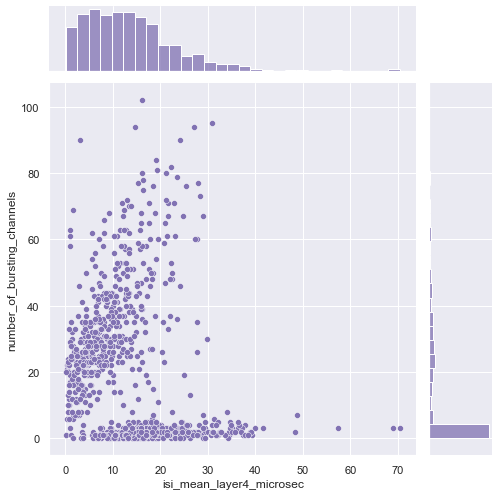

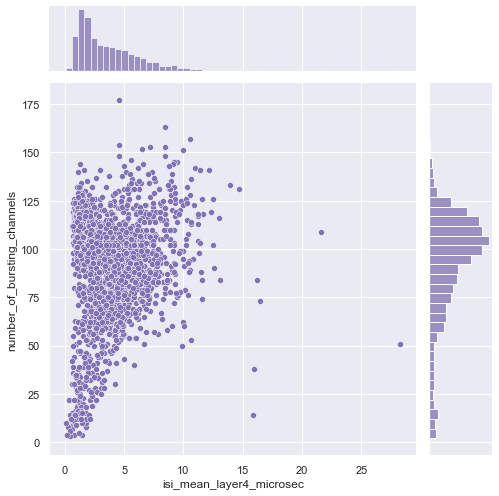

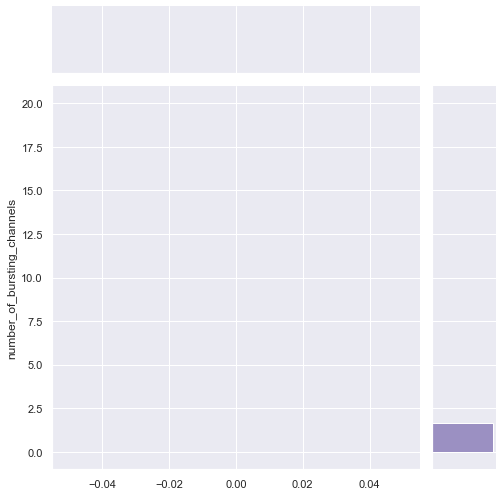

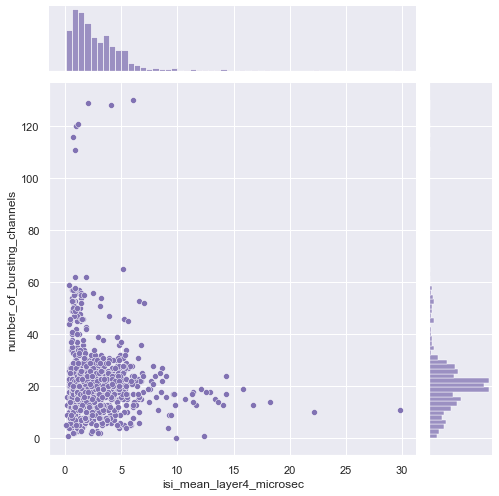

In [436]:
plot = plot_jointplot(df, groupby='recording_date', 
               x_param = 'isi_mean_layer4_microsec', 
               y_param = 'net',
               hue_param = None,
               save = False)

#plot.ax_marg_x.set_xlim(0, 1000)
#plot.ax_marg_y.set_ylim(0, 1200)

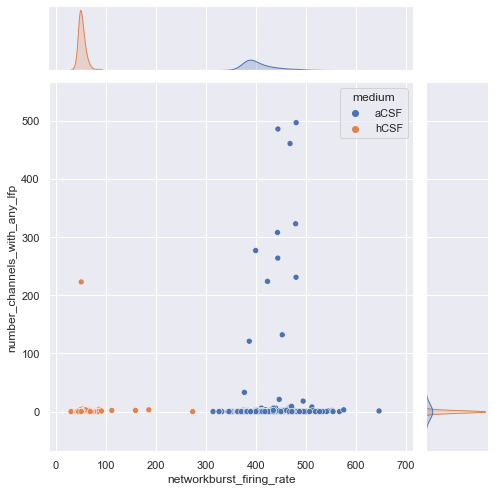

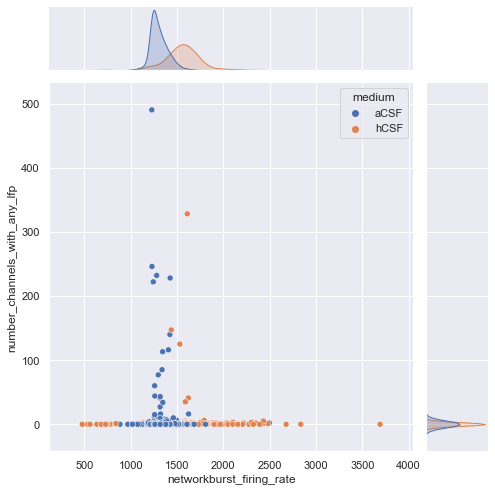

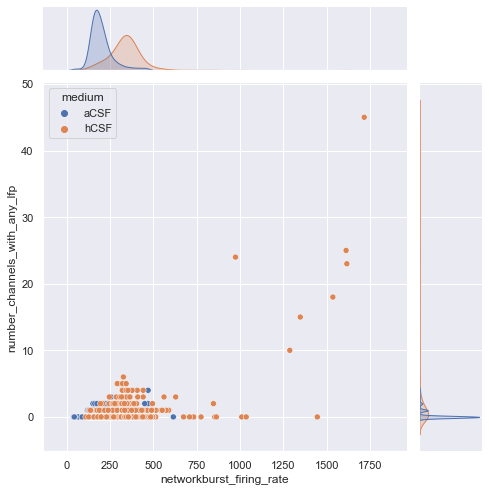

In [247]:
for i in grouped:
    df_of_interest = df.loc[(df[grouper] == i)]
    
    #fig, ax = plt.subplots(1,1, figsize=(12,12))
    xx = 'networkburst_firing_rate'
    yy = 'number_channels_with_any_lfp'
    g = sns.jointplot(x=xx, y=yy,
                      data = df_of_interest, 
                    color="m", height=7, hue = 'medium', ax = ax)
    
    g.figure.savefig('trial_'+i+'_'+xx+'_'+yy+'.png')

In [ ]:
g = sns.jointplot(

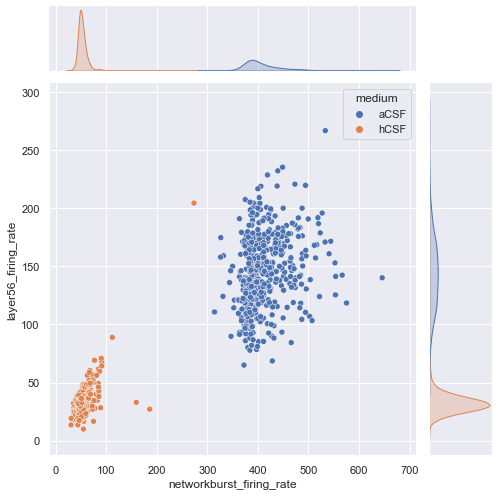

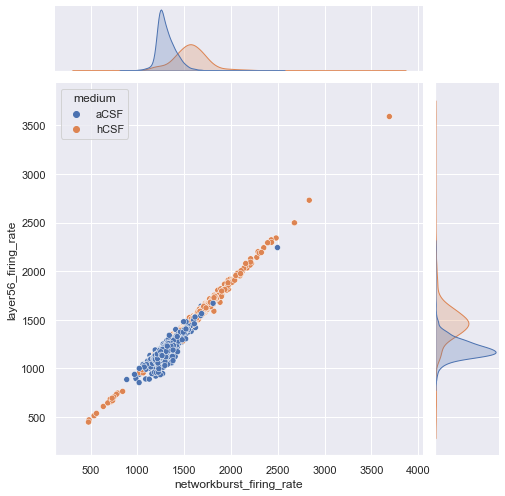

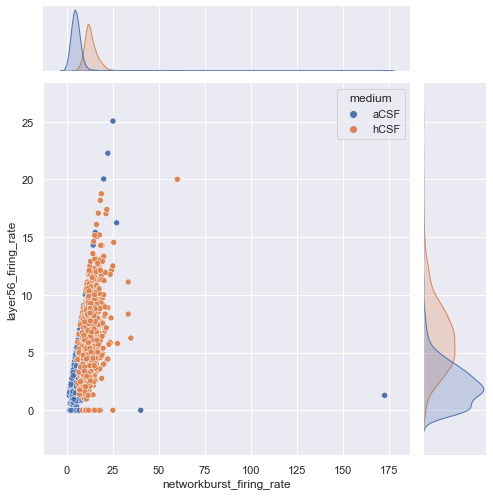

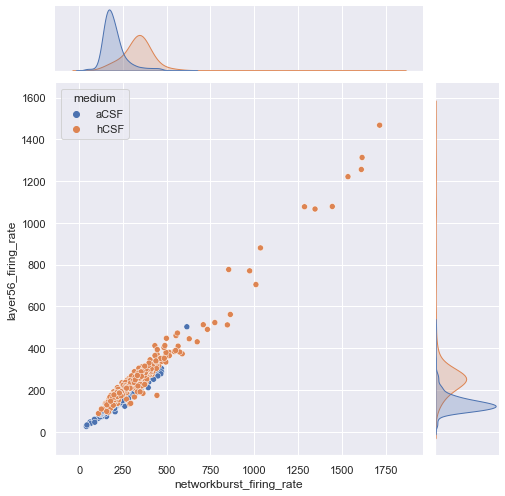

In [437]:
for i in grouped:
    df_of_interest = df.loc[(df[grouper] == i)]
    
    #fig, ax = plt.subplots(1,1, figsize=(12,12))
    
    g = sns.jointplot(x="networkburst_firing_rate", y="layer56_firing_rate",
                      data = df_of_interest, 
                    color="m", height=7, hue = 'medium', ax = ax)

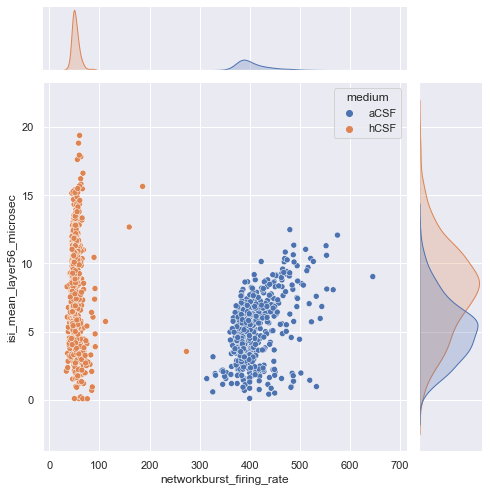

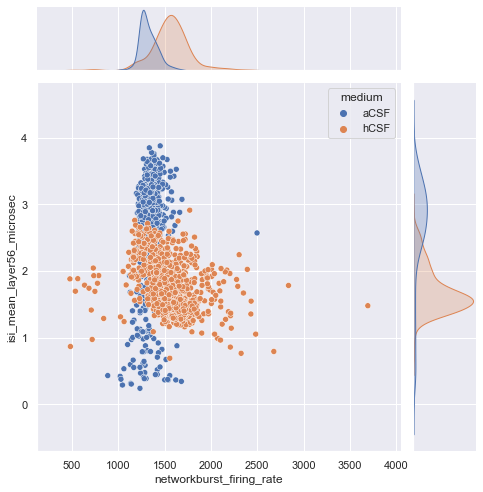

In [88]:
for i in grouped:
    df_of_interest = df.loc[(df[grouper] == i)]
    
    #fig, ax = plt.subplots(1,1, figsize=(12,12))
    
    g = sns.jointplot(x="networkburst_firing_rate", y="isi_mean_layer56_microsec",
                      data = df_of_interest, 
                    color="m", height=7, hue = 'medium', ax = ax)

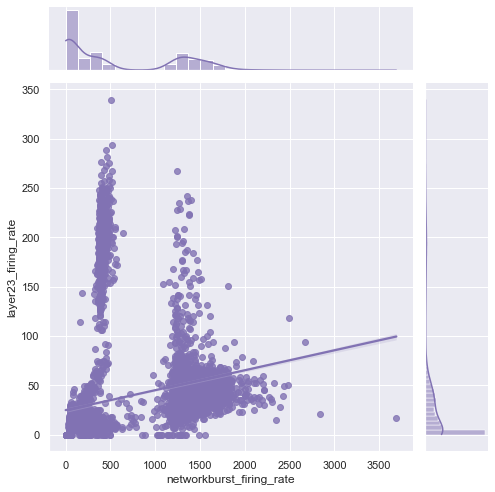

In [440]:
import seaborn as sns
sns.set_theme(style="darkgrid")

g = sns.jointplot(x="networkburst_firing_rate", y="layer23_firing_rate", data=df, 
                    color="m", height=7, kind='reg')

In [240]:
df

filename recording_date  \
0     190415_01_Cortex-synChR2-A_aCSF_nodrug     2019-04-15   
1     190415_01_Cortex-synChR2-A_aCSF_nodrug     2019-04-15   
2     190415_01_Cortex-synChR2-A_aCSF_nodrug     2019-04-15   
3     190415_01_Cortex-synChR2-A_aCSF_nodrug     2019-04-15   
4     190415_01_Cortex-synChR2-A_aCSF_nodrug     2019-04-15   
...                                      ...            ...   
5260            191021_02_cortex_hCSF_nodrug     2019-10-21   
5261            191021_02_cortex_hCSF_nodrug     2019-10-21   
5262            191021_02_cortex_hCSF_nodrug     2019-10-21   
5263            191021_02_cortex_hCSF_nodrug     2019-10-21   
5264            191021_02_cortex_hCSF_nodrug     2019-10-21   

      timelength_recording_s  firingrate_whole_recording_Hz  \
0                     1800.0                        385.713   
1                     1800.0                        385.713   
2                     1800.0                        385.713   
3                     1800.0                        385.713   
4                     1800.0                        385.713   
...                      ...                            ...   
5260                   969.5                        347.728   
5261                   969.5                        347.728   
5262                   969.5                        347.728   
5263                   969.5                        347.728   
5264                   969.5                        347.728   

      active_channels_whole_recording  \
0                                 170   
1                                 170   
2                                 170   
3                                 170   
4                                 170   
...                               ...   
5260                              151   
5261                              151   
5262                              151   
5263                              151   
5264                              151   

                           network_burst_seconds  timelength_network_burst_s  \
0     (0.005639999999999999, 11.990568622864936)                   11.984929   
1        (12.725564245543762, 19.50052330121305)                    6.774959   
2        (19.60052330121305, 26.710480957330674)                    7.109958   
3        (27.22547789022808, 27.285476937341837)                    0.059999   
4        (27.38547693734184, 29.975461512495798)                    2.589985   
...                                          ...                         ...   
5260      (952.0994509864311, 953.2579695743703)                    1.158519   
5261       (953.6589952394262, 953.999628377574)                    0.340633   
5262       (954.099628377574, 954.3957031084933)                    0.296075   
5263      (954.4957031084933, 954.8610909173236)                    0.365388   
5264      (954.9610909173236, 955.6581913132989)                    0.697100   

                                      bursting_channels  \
0     [A11, A14, B11, B14, B5, C11, C12, C13, C15, C...   
1     [A14, B10, B11, C11, C12, C6, C7, D11, D12, D6...   
2     [A10, A11, B10, B11, B12, B5, C11, C6, C7, D15...   
3                                          [D7, H4, M2]   
4     [B11, C11, C13, C6, D11, D6, D7, D8, E10, E11,...   
...                                                 ...   
5260  [D3, E11, E2, F3, F5, F7, F8, G3, G7, H12, I10...   
5261            [E11, F2, F3, F5, F7, G7, K10, L10, L9]   
5262                 [D8, E3, F3, F7, G7, K10, K8, L10]   
5263  [E11, F3, F7, G7, I10, K10, K11, K6, K8, L10, ...   
5264  [E2, F3, F5, F7, G3, G7, G9, I10, K10, K11, K6...   

      number_of_bursting_channels  number_burst_starts  number_burst_ends  \
0                              90                  286                286   
1                              67                  159                159   
2                              73                  154                154   
3                               3                  

In [353]:
df.columns

Index(['filename', 'recording_date', 'timelength_recording_s',
       'firingrate_whole_recording_Hz', 'active_channels_whole_recording',
       'network_burst_seconds', 'timelength_network_burst_s',
       'bursting_channels', 'number_of_bursting_channels',
       'number_burst_starts', 'number_burst_ends', 'active_channels_total',
       'number_of_active_channels', 'number_of_spikes', 'channels_lfp_up',
       'number_channels_with_lfp_up', 'mean_up_lfp_amplitude',
       'channels_lfp_down', 'number_channels_with_lfp_down',
       'mean_down_lfp_amplitude', 'n_layer1_active_channels',
       'n_layer23_active_channels', 'n_layer4_active_channels',
       'n_layer56_active_channels', 'n_whitematter_active_channels',
       'n_spikes_layer1', 'n_spikes_layer23', 'n_spikes_layer4',
       'n_spikes_layer56', 'n_spikes_whitematter', 'isi_mean_layer1_microsec',
       'isi_mean_layer23_microsec', 'isi_mean_layer4_microsec',
       'isi_mean_layer56_microsec', 'isi_mean_whitematter_micro

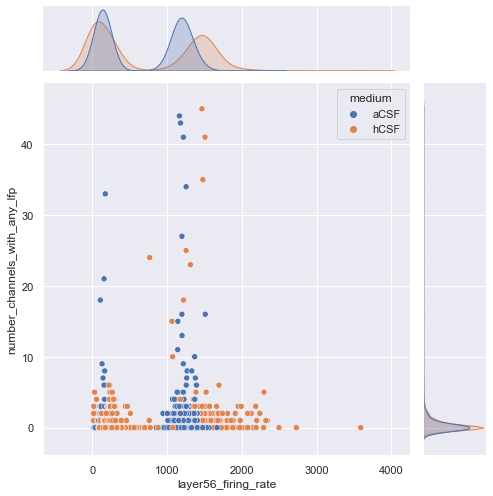

In [391]:
df_low_lfp = df.loc[(df['number_channels_with_any_lfp'] < 50)]

xx="layer56_firing_rate"
yy = "number_channels_with_any_lfp"

g = sns.jointplot(x=xx, y=yy,
              data = df_low_lfp, 
            color="b", height=7,  hue = 'medium')

g.figure.savefig('all_recordings'+'_'+xx+'_'+yy+'.png')

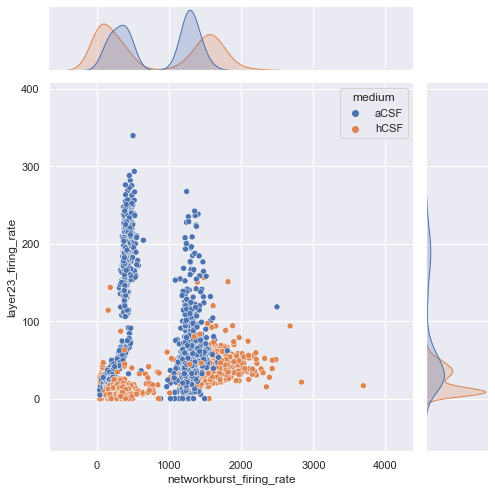

In [246]:
xx="networkburst_firing_rate"
yy = "layer23_firing_rate"

g = sns.jointplot(x=xx, y=yy,
              data = df, 
            color="g", height=7, hue='medium')

g.figure.savefig('all_recordings_medium'+'_'+xx+'_'+yy+'.png')

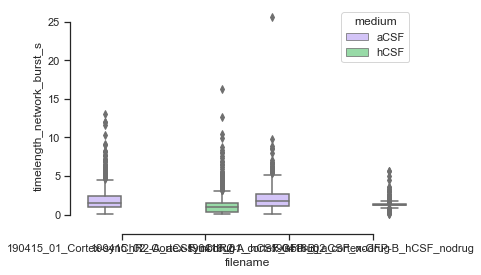

In [52]:
sns.set_theme(style="ticks", palette="pastel")

# Draw a nested boxplot to show bills by day and time
sns.boxplot(x="filename", y="timelength_network_burst_s",
            hue="medium", palette=["m", "g"],
            data=df)
sns.despine(offset=10, trim=True)

In [58]:
df['filename'].unique()

array(['190415_01_Cortex-synChR2-A_aCSF_nodrug',
       '190415_02_Cortex-synChR2-A_hCSF_nodrug',
       '190416_01_cortex-GFP-B_aCSF_nodrug',
       '190416_02_cortex-GFP-B_hCSF_nodrug'], dtype=object)

<AxesSubplot:xlabel='number_channels_with_any_lfp', ylabel='networkburst_firing_rate'>

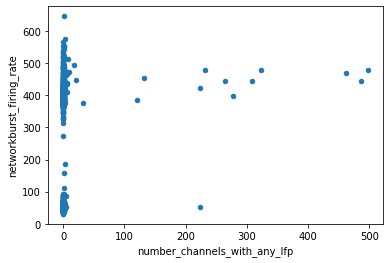

In [107]:
df.plot.scatter(x = 'number_channels_with_any_lfp', y = 'networkburst_firing_rate')

As can be seen above, there are a few channels where almost every channels exhibits a lfp. This is suspicious of an artefact.

Interestingly, the LFP channels are not automatically the channel with the highes intra-burst firing rate but appear to be more in the middle.

In [108]:
# we cutout the number of channels with any lfp above 100 to get a more detailed view:

dff = df.loc[(df['number_channels_with_any_lfp'] <=50)]

<AxesSubplot:xlabel='number_channels_with_any_lfp', ylabel='networkburst_firing_rate'>

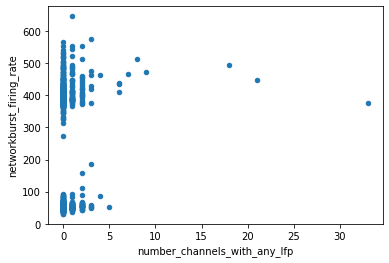

In [109]:
dff.plot.scatter(x = 'number_channels_with_any_lfp', y = 'networkburst_firing_rate')

How many channels actually have any lfp?

In [110]:
df.query('number_channels_with_any_lfp > 0')

filename recording_date  \
0     190415_01_Cortex-synChR2-A_aCSF_nodrug     2019-04-15   
1     190415_01_Cortex-synChR2-A_aCSF_nodrug     2019-04-15   
2     190415_01_Cortex-synChR2-A_aCSF_nodrug     2019-04-15   
3     190415_01_Cortex-synChR2-A_aCSF_nodrug     2019-04-15   
12    190415_01_Cortex-synChR2-A_aCSF_nodrug     2019-04-15   
...                                      ...            ...   
1879  190415_02_Cortex-synChR2-A_hCSF_nodrug     2019-04-15   
1891  190415_02_Cortex-synChR2-A_hCSF_nodrug     2019-04-15   
1895  190415_02_Cortex-synChR2-A_hCSF_nodrug     2019-04-15   
1896  190415_02_Cortex-synChR2-A_hCSF_nodrug     2019-04-15   
1899  190415_02_Cortex-synChR2-A_hCSF_nodrug     2019-04-15   

      timelength_recording_s  firingrate_whole_recording_Hz  \
0                     1800.0                        385.713   
1                     1800.0                        385.713   
2                     1800.0                        385.713   
3                     1800.0                        385.713   
12                    1800.0                        385.713   
...                      ...                            ...   
1879                  1800.0                         46.096   
1891                  1800.0                         46.096   
1895                  1800.0                         46.096   
1896                  1800.0                         46.096   
1899                  1800.0                         46.096   

      active_channels_whole_recording  \
0                                 170   
1                                 170   
2                                 170   
3                                 170   
12                                170   
...                               ...   
1879                               75   
1891                               75   
1895                               75   
1896                               75   
1899                               75   

                           network_burst_seconds  timelength_network_burst_s  \
0     (0.005639999999999999, 11.990568622864936)                   11.984929   
1        (12.725564245543762, 19.50052330121305)                    6.774959   
2        (19.60052330121305, 26.710480957330674)                    7.109958   
3        (27.22547789022808, 27.285476937341837)                    0.059999   
12        (50.16034129994083, 57.78529588895586)                    7.624955   
...                                          ...                         ...   
1879      (1746.91555710023, 1751.2354973812849)                    4.319940   
1891    (1773.9301920985772, 1775.7251664950927)                    1.794974   
1895      (1777.725140824053, 1778.020135487179)                    0.294995   
1896     (1778.120135487179, 1778.8951236649896)                    0.774988   
1899      (1779.2351204223319, 1782.18008063222)                    2.944960   

                                      bursting_channels  \
0     [A11, A14, B11, B14, B5, C11, C12, C13, C15, C...   
1     [A14, B10, B11, C11, C12, C6, C7, D11, D12, D6...   
2     [A10, A11, B10, B11, B12, B5, C11, C6, C7, D15...   
3                                          [D7, H4, M2]   
12    [A11, B11, B13, B5, C11, C12, C15, C6, C7, D12...   
...                                                 ...   
1879                                           [C6, O1]   
1891                                       [D3, N1, O1]   
1895                                                 []   
1896                                               [O1]   
1899                               [K1, M1, N1, N3, O1]   

      number_of_bursting_channels  number_burst_starts  number_burst_ends  \
0                              90                  286                286   
1                              67                  159                159   
2                              73                  154                154   
3                               3                  

<AxesSubplot:ylabel='Frequency'>

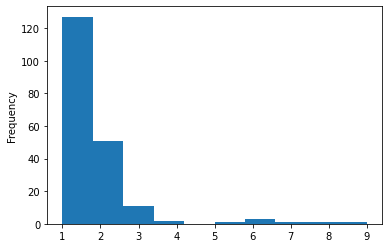

In [111]:
df.query('number_channels_with_any_lfp > 0 and number_channels_with_any_lfp <10')['number_channels_with_any_lfp'].plot.hist()

In [112]:
# overview of all columns

df.columns

Index(['filename', 'recording_date', 'timelength_recording_s',
       'firingrate_whole_recording_Hz', 'active_channels_whole_recording',
       'network_burst_seconds', 'timelength_network_burst_s',
       'bursting_channels', 'number_of_bursting_channels',
       'number_burst_starts', 'number_burst_ends', 'active_channels_total',
       'number_of_active_channels', 'number_of_spikes', 'channels_lfp_up',
       'number_channels_with_lfp_up', 'mean_up_lfp_amplitude',
       'channels_lfp_down', 'number_channels_with_lfp_down',
       'mean_down_lfp_amplitude', 'n_layer1_active_channels',
       'n_layer23_active_channels', 'n_layer4_active_channels',
       'n_layer56_active_channels', 'n_whitematter_active_channels',
       'n_spikes_layer1', 'n_spikes_layer23', 'n_spikes_layer4',
       'n_spikes_layer56', 'n_spikes_whitematter', 'isi_mean_layer1_microsec',
       'isi_mean_layer23_microsec', 'isi_mean_layer4_microsec',
       'isi_mean_layer56_microsec', 'isi_mean_whitematter_micro

#### we save the original df before further processing

In [126]:
df_orig = df

In [127]:
# preparing the dataset for PCA
df = df_orig
df_no_string = df.select_dtypes(include=['int64', 'float'])

In [128]:
df_no_string = df_no_string.dropna(axis = 1)

In [129]:
df = df_no_string

In [130]:
df

timelength_recording_s  firingrate_whole_recording_Hz  \
0                     1800.0                        385.713   
1                     1800.0                        385.713   
2                     1800.0                        385.713   
3                     1800.0                        385.713   
4                     1800.0                        385.713   
...                      ...                            ...   
1907                  1800.0                         46.096   
1909                  1800.0                         46.096   
1911                  1800.0                         46.096   
1913                  1800.0                         46.096   
1915                  1800.0                         46.096   

      active_channels_whole_recording  timelength_network_burst_s  \
0                                 170                   11.984929   
1                                 170                    6.774959   
2                                 170                    7.109958   
3                                 170                    0.059999   
4                                 170                    2.589985   
...                               ...                         ...   
1907                               75                    1.579979   
1909                               75                    0.219996   
1911                               75                    0.739989   
1913                               75                    1.099985   
1915                               75                    0.744989   

      number_of_bursting_channels  number_burst_starts  number_burst_ends  \
0                              90                  286                286   
1                              67                  159                159   
2                              73                  154                154   
3                               3                    3                  3   
4                              44                   54                 54   
...                           ...                  ...                ...   
1907                            2                    2                  2   
1909                            1                    0                  0   
1911                            1                    2                  2   
1913                            2                    4                  4   
1915                            0                    0                  0   

      number_of_active_channels  number_of_spikes  \
0                           166              5850   
1                           151              3177   
2                           145              3321   
3                            21                29   
4                           120              1045   
...                         ...               ...   
1907                         29                77   
1909                          8                10   
1911                         16                34   
1913                         24                57   
1915                         18                38   

      number_channels_with_lfp_up  mean_up_lfp_amplitude  \
0                               1               8.268715   
1                               0               0.000000   
2                               3               6.573036   
3                               1               5.142590   
4                               0               0.000000   
...                           ...                    ...   
1907                            0               0.000000   
1909                            0               0.000000   
1911                            0               0.000000   
1913                            0               0.000000   
1915                            0               0.000000   

      number_channels_with_lfp_down  mean_down_lfp_amplitude  \
0                                 0                 0.000000   
1        

In [118]:
df = df_orig.fillna(0)

In [137]:
from clustergrammer_widget import *
net = Network(clustergrammer_widget)

In [138]:
net.load_df(df)

In [139]:
net.cluster()

AttributeError: 'DataFrame' object has no attribute 'ix'

In [253]:
print(df.dtypes)

filename                            object
recording_date                      object
timelength_recording_s             float64
firingrate_whole_recording_Hz      float64
active_channels_whole_recording      int64
                                    ...   
layer23_firing_rate                float64
layer4_firing_rate                 float64
layer56_firing_rate                float64
whitematter_firing_rate            float64
number_channels_with_any_lfp         int64
Length: 67, dtype: object


In [254]:
list(df.columns)

['filename',
 'recording_date',
 'timelength_recording_s',
 'firingrate_whole_recording_Hz',
 'active_channels_whole_recording',
 'network_burst_seconds',
 'timelength_network_burst_s',
 'bursting_channels',
 'number_of_bursting_channels',
 'number_burst_starts',
 'number_burst_ends',
 'active_channels_total',
 'number_of_active_channels',
 'number_of_spikes',
 'channels_lfp_up',
 'number_channels_with_lfp_up',
 'mean_up_lfp_amplitude',
 'channels_lfp_down',
 'number_channels_with_lfp_down',
 'mean_down_lfp_amplitude',
 'n_layer1_active_channels',
 'n_layer23_active_channels',
 'n_layer4_active_channels',
 'n_layer56_active_channels',
 'n_whitematter_active_channels',
 'n_spikes_layer1',
 'n_spikes_layer23',
 'n_spikes_layer4',
 'n_spikes_layer56',
 'n_spikes_whitematter',
 'isi_mean_layer1_microsec',
 'isi_mean_layer23_microsec',
 'isi_mean_layer4_microsec',
 'isi_mean_layer56_microsec',
 'isi_mean_whitematter_microsec',
 'isi_std_layer1',
 'isi_std_layer23',
 'isi_std_layer4',
 'isi_

In [255]:
features = df[['timelength_recording_s',
 'firingrate_whole_recording_Hz',
 'active_channels_whole_recording',
 'timelength_network_burst_s',
 'number_of_bursting_channels',
 'number_burst_starts',
 'number_burst_ends',
 'number_of_active_channels',
 'number_of_spikes',
 'number_channels_with_lfp_up',
 'mean_up_lfp_amplitude',
 'number_channels_with_lfp_down',
 'mean_down_lfp_amplitude',
 'n_layer1_active_channels',
 'n_layer23_active_channels',
 'n_layer4_active_channels',
 'n_layer56_active_channels',
 'n_whitematter_active_channels',
 'n_spikes_layer1',
 'n_spikes_layer23',
 'n_spikes_layer4',
 'n_spikes_layer56',
 'n_spikes_whitematter',
 'isi_mean_layer1_microsec',
 'isi_mean_layer23_microsec',
 'isi_mean_layer4_microsec',
 'isi_mean_layer56_microsec',
 'isi_mean_whitematter_microsec',
 'isi_std_layer1',
 'isi_std_layer23',
 'isi_std_layer4',
 'isi_std_layer56',
 "isi_std_whitematter'",
 'channels_covered_layer1',
 'channels_covered_layer23',
 'channels_covered_layer4',
 'channels_covered_layer56',
 'channels_covered_whitematter',
 'any_lfp_deviation',
 'num_medium',
 'bursting_to_active_channels_ratio',
 'networkburst_firing_rate',
 'layer1_percent_of_active_channels',
 'layer23_percent_of_active_channels',
 'layer4_percent_of_active_channels',
 'layer56_percent_of_active_channels',
 'whitematter_percent_of_active_channels',
 'layer1_percent_of_covered_channels',
 'layer23_percent_of_covered_channels',
 'layer4_percent_of_covered_channels',
 'layer56_percent_of_covered_channels',
 'whitematter_percent_of_covered_channels',
 'layer1_firing_rate',
 'layer23_firing_rate',
 'layer4_firing_rate',
 'layer56_firing_rate',
 'whitematter_firing_rate',
 'number_channels_with_any_lfp']]
               

In [293]:
number_of_features = len(features.columns) 

In [294]:
feature_dic = {}
count = 0
for i in features.columns:
    feature_dic[count]=i
    count += 1

In [295]:
feature_dic

{0: 'timelength_recording_s',
 1: 'firingrate_whole_recording_Hz',
 2: 'active_channels_whole_recording',
 3: 'timelength_network_burst_s',
 4: 'number_of_bursting_channels',
 5: 'number_burst_starts',
 6: 'number_burst_ends',
 7: 'number_of_active_channels',
 8: 'number_of_spikes',
 9: 'number_channels_with_lfp_up',
 10: 'mean_up_lfp_amplitude',
 11: 'number_channels_with_lfp_down',
 12: 'mean_down_lfp_amplitude',
 13: 'n_layer1_active_channels',
 14: 'n_layer23_active_channels',
 15: 'n_layer4_active_channels',
 16: 'n_layer56_active_channels',
 17: 'n_whitematter_active_channels',
 18: 'n_spikes_layer1',
 19: 'n_spikes_layer23',
 20: 'n_spikes_layer4',
 21: 'n_spikes_layer56',
 22: 'n_spikes_whitematter',
 23: 'isi_mean_layer1_microsec',
 24: 'isi_mean_layer23_microsec',
 25: 'isi_mean_layer4_microsec',
 26: 'isi_mean_layer56_microsec',
 27: 'isi_mean_whitematter_microsec',
 28: 'isi_std_layer1',
 29: 'isi_std_layer23',
 30: 'isi_std_layer4',
 31: 'isi_std_layer56',
 32: "isi_std_wh

### Preprocessing for PCA

In [296]:
from sklearn import preprocessing

columns = features.columns
x = features.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
pca_df = pd.DataFrame(x_scaled)

In [297]:
pca_df.head()

0         1      2         3         4         5         6         7   \
0  1.0  0.240758  0.625  0.294462  0.508475  0.052095  0.052095  0.721461   
1  1.0  0.240758  0.625  0.166189  0.378531  0.028962  0.028962  0.652968   
2  1.0  0.240758  0.625  0.174437  0.412429  0.028051  0.028051  0.625571   
3  1.0  0.240758  0.625  0.000862  0.016949  0.000546  0.000546  0.059361   
4  1.0  0.240758  0.625  0.063152  0.248588  0.009836  0.009836  0.511416   

         8         9         10        11        12   13        14        15  \
0  0.083775  0.004065  0.007119  0.000000       NaN  1.0  0.910448  0.451613   
1  0.045444  0.000000       NaN  0.003968  0.968254  1.0  0.865672  0.516129   
2  0.047509  0.012195  0.004283  0.015873  0.966357  1.0  0.761194  0.483871   
3  0.000301  0.004065  0.001891  0.000000       NaN  1.0  0.149254  0.064516   
4  0.014871  0.000000       NaN  0.000000       NaN  1.0  0.686567  0.354839   

         16        17        18        19        20        21        22  \
0  0.435897  0.527778  1.000000  0.851504  0.027233  0.032285  0.317267   
1  0.378205  0.388889  0.538362  0.490133  0.010802  0.017065  0.129957   
2  0.378205  0.444444  0.557867  0.492397  0.008215  0.017417  0.241611   
3  0.032051  0.000000  0.005202  0.004206  0.000304  0.000151  0.000000   
4  0.314103  0.277778  0.130039  0.161436  0.003803  0.006638  0.026236   

         23        24        25        26        27        28        29  \
0  0.043447  0.171830  0.342538  0.583191  0.073309  0.128056  0.333092   
1  0.044029  0.147265  0.412124  0.520214  0.065858  0.141115  0.221719   
2  0.042992  0.139821  0.402098  0.486793  0.039198  0.109947  0.204331   
3  0.006441  0.006961       NaN  0.047258       NaN  0.000000  0.006160   
4  0.051295  0.125516  0.220351  0.350864  0.043642  0.097147  0.161104   

         30        31        32   33   34        35        36   37   38   39  \
0  0.917332  0.630201  0.349934  1.0  1.0  0.769231  0.396552  0.0  0.0  0.0   
1  0.777817  0.447822  0.238224  1.0  1.0  0.769231  0.396552  0.0  1.0  0.0   
2  0.783108  0.483819  0.198353  1.0  1.0  0.769231  0.396552  0.0  1.0  0.0   
3       NaN  0.016459       NaN  1.0  1.0  0.769231  0.396552  0.0  0.0  0.0   
4  0.342051  0.266173  0.093757  1.0  1.0  0.769231  0.396552  0.0  0.0  0.0   

         40        41        42        43        44        45        46   47  \
0  0.664052  0.124959  0.060241  0.601314  0.189759  0.263965  0.457831  1.0   
1  0.543457  0.119721  0.066225  0.628537  0.238411  0.241421  0.370861  1.0   
2  0.616627  0.119218  0.068966  0.575549  0.232759  0.262696  0.441379  1.0   
3  0.174972  0.123655  0.476190  0.779221  0.214286  0.151515  0.000000  1.0   
4  0.449096  0.101847  0.083333  0.627273  0.206250  0.268182  0.333333  1.0   

         48        49        50        51        52        53        54  \
0  0.910448  0.500000  0.559959  0.826087  0.573582  0.646788  0.046489   
1  0.865672  0.571429  0.485847  0.608696  0.546259  0.658594  0.032620   
2  0.761194  0.535714  0.485847  0.695652  0.539380  0.630463  0.023641   
3  0.149254  0.071429  0.041173  0.000000  0.595964  0.638132  0.103757   
4  0.686567  0.392857  0.403500  0.434783  0.345150  0.567434  0.030045   

         55        56        57  
0  0.042144  0.229954  0.002012  
1  0.039263  0.166627  0.002012  
2  0.038106  0.295190  0.014085  
3  0.048420  0.000000  0.002012  
4  0.040133  0.087992  0.000000

In [298]:
pca_df.rename(columns = feature_dic)

timelength_recording_s  firingrate_whole_recording_Hz  \
0                   1.000000                       0.240758   
1                   1.000000                       0.240758   
2                   1.000000                       0.240758   
3                   1.000000                       0.240758   
4                   1.000000                       0.240758   
...                      ...                            ...   
4502                0.077222                       0.213830   
4503                0.077222                       0.213830   
4504                0.077222                       0.213830   
4505                0.077222                       0.213830   
4506                0.077222                       0.213830   

      active_channels_whole_recording  timelength_network_burst_s  \
0                               0.625                    0.294462   
1                               0.625                    0.166189   
2                               0.625                    0.174437   
3                               0.625                    0.000862   
4                               0.625                    0.063152   
...                               ...                         ...   
4502                            0.500                    0.027908   
4503                            0.500                    0.007771   
4504                            0.500                    0.006674   
4505                            0.500                    0.008381   
4506                            0.500                    0.016548   

      number_of_bursting_channels  number_burst_starts  number_burst_ends  \
0                        0.508475             0.052095           0.052095   
1                        0.378531             0.028962           0.028962   
2                        0.412429             0.028051           0.028051   
3                        0.016949             0.000546           0.000546   
4                        0.248588             0.009836           0.009836   
...                           ...                  ...                ...   
4502                     0.118644             0.005100           0.005100   
4503                     0.050847             0.002004           0.002004   
4504                     0.045198             0.001275           0.001275   
4505                     0.067797             0.001821           0.001821   
4506                     0.073446             0.002186           0.002186   

      number_of_active_channels  number_of_spikes  \
0                      0.721461          0.083775   
1                      0.652968          0.045444   
2                      0.625571          0.047509   
3                      0.059361          0.000301   
4                      0.511416          0.014871   
...                         ...               ...   
4502                   0.378995          0.005765   
4503                   0.255708          0.001836   
4504                   0.178082          0.001477   
4505                   0.196347          0.001750   
4506                   0.310502          0.003212   

      number_channels_with_lfp_up  mean_up_lfp_amplitude  \
0                        0.004065               0.007119   
1                        0.000000                    NaN   
2                        0.012195               0.004283   
3                        0.004065               0.001891   
4                        0.000000                    NaN   
...                           ...                    ...   
4502                     0.008130               0.035952   
4503                     0.000000                    NaN   
4504                     0.004065               0.017951   
4505                     0.000000                    NaN   
4506                     0.008130               0.091651   

      number_channels_with_lfp_down  mean_down_lfp_amplitude  \
0                          0.000000                      NaN   
1        

### PCA with 3 components

In [299]:
pca = PCA(n_components = 3)

In [300]:
pca_result = pca.fit_transform(pca_df.values)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [151]:
pca_result

array([[ 2.47494521,  1.17570998,  0.99809369],
       [ 2.1741286 ,  1.09092034,  0.96239577],
       [ 2.17752257,  1.09407041,  1.01549447],
       ...,
       [-1.09443869, -0.2364333 , -0.01112025],
       [-0.99115942,  0.03835195, -0.03819378],
       [-1.08934324, -0.0353514 , -0.08377453]])

In [152]:
pca_df['pca-one'] = pca_result[:,0]
pca_df['pca-two'] = pca_result[:,1]
pca_df['pca-three'] = pca_result[:,2]
#df['pca-four'] = pca_result[:,3]

In [153]:
pca_df = pca_df.rename(columns = feature_dic)

In [154]:
pca.explained_variance_ratio_

array([0.66999   , 0.10669555, 0.06281641])

In [984]:
pca.components_[1]

array([ 0.12732577,  0.04477191, -0.00425937,  0.05077666,  0.04304825,
        0.09417183, -0.9821528 ,  0.02362013, -0.05730358])

So the first 3 principal components explain 83% of the variance in the data.

In [985]:
rndperm = np.random.permutation(pca_df.shape[0])

In [986]:
pca_df['num_medium'] = df['num_medium']

In [987]:
rndperm

array([ 641,  192, 3618, ...,  950, 4263, 3539])

In [156]:
pca_df

timelength_recording_s  firingrate_whole_recording_Hz  \
0                        0.0                            1.0   
1                        0.0                            1.0   
2                        0.0                            1.0   
3                        0.0                            1.0   
4                        0.0                            1.0   
...                      ...                            ...   
1325                     0.0                            0.0   
1326                     0.0                            0.0   
1327                     0.0                            0.0   
1328                     0.0                            0.0   
1329                     0.0                            0.0   

      active_channels_whole_recording  timelength_network_burst_s  \
0                                 1.0                7.363440e-01   
1                                 1.0                4.146373e-01   
2                                 1.0                4.353229e-01   
3                                 1.0                3.071328e-15   
4                                 1.0                1.562223e-01   
...                               ...                         ...   
1325                              0.0                9.385614e-02   
1326                              0.0                9.879519e-03   
1327                              0.0                4.198820e-02   
1328                              0.0                6.421736e-02   
1329                              0.0                4.229693e-02   

      number_of_bursting_channels  number_burst_starts  number_burst_ends  \
0                        0.882353             0.740933           0.740933   
1                        0.656863             0.411917           0.411917   
2                        0.715686             0.398964           0.398964   
3                        0.029412             0.007772           0.007772   
4                        0.431373             0.139896           0.139896   
...                           ...                  ...                ...   
1325                     0.019608             0.005181           0.005181   
1326                     0.009804             0.000000           0.000000   
1327                     0.009804             0.005181           0.005181   
1328                     0.019608             0.010363           0.010363   
1329                     0.000000             0.000000           0.000000   

      number_of_active_channels  number_of_spikes  \
0                      0.734884          0.848881   
1                      0.665116          0.460477   
2                      0.637209          0.481401   
3                      0.060465          0.003051   
4                      0.520930          0.150683   
...                         ...               ...   
1325                   0.097674          0.010026   
1326                   0.000000          0.000291   
1327                   0.037209          0.003778   
1328                   0.074419          0.007120   
1329                   0.046512          0.004359   

      number_channels_with_lfp_up  mean_up_lfp_amplitude  \
0                        0.004065               0.222700   
1                        0.000000               0.000000   
2                        0.012195               0.177031   
3                        0.004065               0.138505   
4                        0.000000               0.000000   
...                           ...                    ...   
1325                     0.000000               0.000000   
1326                     0.000000               0.000000   
1327                     0.000000               0.000000   
1328                     0.000000               0.000000   
1329                     0.000000               0.000000   

      number_channels_with_lfp_down  mean_down_lfp_amplitude  \
0                          0.000000                 1.000000   
1        

In [157]:
import seaborn as sns


<AxesSubplot:xlabel='pca-one', ylabel='pca-two'>

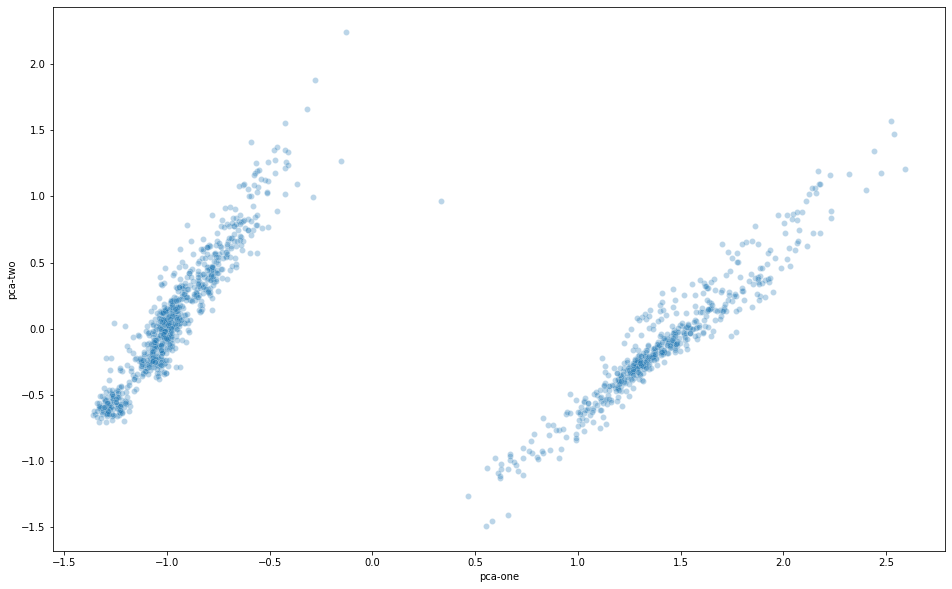

In [159]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="pca-one", y="pca-two",
    palette=sns.color_palette("hls", 10),
    data=pca_df,
    legend="full",
    alpha=0.3
)

In [993]:
def myplot(score,coeff,labels=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    plt.scatter(xs * scalex,ys * scaley, c = y)
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5)
        if labels is None:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'g', ha = 'center', va = 'center')
        else:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'g', ha = 'center', va = 'center')
    plt.xlim(-1,1)
    plt.ylim(-1,1)
    plt.xlabel("PC{}".format(1))
    plt.ylabel("PC{}".format(2))
    plt.grid()

In [1001]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.decomposition import PCA
import pandas as pd
from sklearn.preprocessing import StandardScaler

iris = datasets.load_iris()
X = iris.data
y = iris.target
#In general a good idea is to scale the data
scaler = StandardScaler()
scaler.fit(X)
X=scaler.transform(X)    




In [1000]:
iris

{'data': array([[5.1, 3.5, 1.4, 0.2],
        [4.9, 3. , 1.4, 0.2],
        [4.7, 3.2, 1.3, 0.2],
        [4.6, 3.1, 1.5, 0.2],
        [5. , 3.6, 1.4, 0.2],
        [5.4, 3.9, 1.7, 0.4],
        [4.6, 3.4, 1.4, 0.3],
        [5. , 3.4, 1.5, 0.2],
        [4.4, 2.9, 1.4, 0.2],
        [4.9, 3.1, 1.5, 0.1],
        [5.4, 3.7, 1.5, 0.2],
        [4.8, 3.4, 1.6, 0.2],
        [4.8, 3. , 1.4, 0.1],
        [4.3, 3. , 1.1, 0.1],
        [5.8, 4. , 1.2, 0.2],
        [5.7, 4.4, 1.5, 0.4],
        [5.4, 3.9, 1.3, 0.4],
        [5.1, 3.5, 1.4, 0.3],
        [5.7, 3.8, 1.7, 0.3],
        [5.1, 3.8, 1.5, 0.3],
        [5.4, 3.4, 1.7, 0.2],
        [5.1, 3.7, 1.5, 0.4],
        [4.6, 3.6, 1. , 0.2],
        [5.1, 3.3, 1.7, 0.5],
        [4.8, 3.4, 1.9, 0.2],
        [5. , 3. , 1.6, 0.2],
        [5. , 3.4, 1.6, 0.4],
        [5.2, 3.5, 1.5, 0.2],
        [5.2, 3.4, 1.4, 0.2],
        [4.7, 3.2, 1.6, 0.2],
        [4.8, 3.1, 1.6, 0.2],
        [5.4, 3.4, 1.5, 0.4],
        [5.2, 4.1, 1.5, 0.1],
  

In [1002]:

pca = PCA()
x_new = pca.fit_transform(X)

def myplot(score,coeff,labels=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    plt.scatter(xs * scalex,ys * scaley, c = y)
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5)
        if labels is None:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'g', ha = 'center', va = 'center')
        else:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'g', ha = 'center', va = 'center')
    plt.xlim(-1,1)
    plt.ylim(-1,1)
    plt.xlabel("PC{}".format(1))
    plt.ylabel("PC{}".format(2))
    plt.grid()

In [1006]:
x_new.shape

(150, 4)

In [1007]:
pca.components_

array([[ 0.52106591, -0.26934744,  0.5804131 ,  0.56485654],
       [ 0.37741762,  0.92329566,  0.02449161,  0.06694199],
       [-0.71956635,  0.24438178,  0.14212637,  0.63427274],
       [-0.26128628,  0.12350962,  0.80144925, -0.52359713]])

In [1009]:
x_new[:,0:2]

array([[-2.26470281,  0.4800266 ],
       [-2.08096115, -0.67413356],
       [-2.36422905, -0.34190802],
       [-2.29938422, -0.59739451],
       [-2.38984217,  0.64683538],
       [-2.07563095,  1.48917752],
       [-2.44402884,  0.0476442 ],
       [-2.23284716,  0.22314807],
       [-2.33464048, -1.11532768],
       [-2.18432817, -0.46901356],
       [-2.1663101 ,  1.04369065],
       [-2.32613087,  0.13307834],
       [-2.2184509 , -0.72867617],
       [-2.6331007 , -0.96150673],
       [-2.1987406 ,  1.86005711],
       [-2.26221453,  2.68628449],
       [-2.2075877 ,  1.48360936],
       [-2.19034951,  0.48883832],
       [-1.898572  ,  1.40501879],
       [-2.34336905,  1.12784938],
       [-1.914323  ,  0.40885571],
       [-2.20701284,  0.92412143],
       [-2.7743447 ,  0.45834367],
       [-1.81866953,  0.08555853],
       [-2.22716331,  0.13725446],
       [-1.95184633, -0.62561859],
       [-2.05115137,  0.24216355],
       [-2.16857717,  0.52714953],
       [-2.13956345,

In [1012]:
np.transpose(pca.components_[0:2, :])

array([[ 0.52106591,  0.37741762],
       [-0.26934744,  0.92329566],
       [ 0.5804131 ,  0.02449161],
       [ 0.56485654,  0.06694199]])

In [851]:
myplot(x_new[:,0:2],np.transpose(pca.components_[0:2, :]))
plt.show()

(150, 2)

In [852]:
pca.components_

array([[ 0.52106591, -0.26934744,  0.5804131 ,  0.56485654],
       [ 0.37741762,  0.92329566,  0.02449161,  0.06694199],
       [-0.71956635,  0.24438178,  0.14212637,  0.63427274],
       [-0.26128628,  0.12350962,  0.80144925, -0.52359713]])

In [853]:
X.shape

(150, 4)